## Task
Obtain a bunch of leading indicators, which should be highly correlated with UK inflation or UK inflation expectations.


1. Extract the fequency of negative keywords and check the correlations with inflation rate.
2. Craft it more and extract the frequency of the keywords that are related to inflation and check the correlation with inflation rate.
3. Model the keywords (either of all tweets or only that have some keywords) with tf-idf and use the top 10 highest scores keywords to repeat 2.
4. Predict the inflation score using historical data of inflation plus other features extracted from the tweets, for example the frequency of some keywords you indetified from 3.


Last year student: https://github.com/MichelangeloSaveriano/forecasting-inflation-using-tweets


## Requirements
1. Build at least 3 textual-based indicators that should correlate with Inflation
2. Do forecasting using at least 3 models:
    1. One benchmark like an AR(I)MA
    2. LSTM, or RNN, or CNN, .. etc.
    3. XGBoost, or BART, or RF or tree, .. etc.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle

## Data
Sample of 844,249 tweets on inflation in the UK for the period 2018-2022. The file has 27 columns.

In [ ]:
data = pd.read_parquet('part-00000-64a259cf-ea32-483e-b267-f4a0854c7dc3-c000.snappy.parquet')

In [ ]:
data.shape

(844249, 27)

In [ ]:
data.columns

Index(['id', 'verb', 'user', 'link', 'body', 'retweetbody', 'date',
       'postedtime', 'retweetcount', 'favoritescount', 'generator',
       'twitter_lang', 'year', 'userLocation', 'userFriends', 'userFollowers',
       'userNumTweets', 'userVerified', 'userLanguage', 'userBio', 'country',
       'countrycode', 'locality', 'region', 'subregion', 'locationname',
       'inreplyto.link'],
      dtype='object')

In [ ]:
data['date'].sort_values()

33786     2018-01-01
113785    2018-01-01
117986    2018-01-01
785283    2018-01-01
215226    2018-01-01
             ...    
33781     2022-12-31
33782     2022-12-31
33783     2022-12-31
147534    2022-12-31
299479    2022-12-31
Name: date, Length: 844249, dtype: object

In [ ]:
data.iloc[0]

id                                                      -1412257600
verb                                                           post
user                                                     -931661990
link              http://twitter.com/ahlaamomarr/statuses/100070...
body              After successfully making iftar for your whole...
retweetbody                                                    None
date                                                     2018-05-27
postedtime                                 2018-05-27T11:42:52.000Z
retweetcount                                                      0
favoritescount                                                    0
generator                                        Twitter for iPhone
twitter_lang                                                     en
year                                                           2018
userLocation                                        London, England
userFriends                                     

In [ ]:
data.iloc[1]

id                                                        531418800
verb                                                          share
user                                                     1115606588
link              http://twitter.com/platypusbanker/statuses/100...
body              RT @BrexitBin: If you still think this is an a...
retweetbody       If you still think this is an acceptable price...
date                                                     2018-05-28
postedtime                                 2018-05-28T14:30:42.000Z
retweetcount                                                     87
favoritescount                                                    0
generator                                        Twitter for iPhone
twitter_lang                                                     en
year                                                           2018
userLocation                                    South East, England
userFriends                                     

### Description
* |-- id: integer (nullable = false) (hashed id)
* |-- verb: string (nullable = true) (can be post or share if a RT)
* |-- user: integer (nullable = false) (hashed user id)
* |-- inreplyto: struct (nullable = true) (in reply to)
    * |-- link: string (nullable = true)
* |-- link: string (nullable = true)
* |-- body: string (nullable = true) (body of tweet)
* |-- retweetbody: string (nullable = true) (body of retweeted tweet)
* |-- date: string (nullable = true) (date)
* |-- postedtime: string (nullable = true) (date and time)
* |-- retweetcount: long (nullable = true) (number of RT)
* |-- favoritescount: long (nullable = true) (number of likes)
* |-- generator: string (nullable = true) (generator)
* |-- twitter_lang: string (nullable = true) (language)
* |-- year: string (nullable = true) (year)
* |-- userLocation: string (nullable = true) (user location)
* |-- userFriends: long (nullable = true) (user friends)
* |-- userFollowers: long (nullable = true) (user followers)
* |-- userNumTweets: long (nullable = true) (number of tweets)
* |-- userVerified: boolean (nullable = true) (verified)
* |-- userLanguage: string (nullable = true) (user language)
* |-- userBio: string (nullable = true) (user bio)
* |-- country: string (nullable = true) (country)
* |-- countrycode: string (nullable = true) (country code)
* |-- locality: string (nullable = true) (locality)
* |-- region: string (nullable = true) (region)
* |-- subregion: string (nullable = true) (sub region)
* |-- locationname: string (nullable = true) (location name)

In [ ]:
data['verb'].value_counts()

share    493552
post     350697
Name: verb, dtype: int64

In [ ]:
data['link'].value_counts()

http://twitter.com/ahlaamomarr/statuses/1000703881368821760        1
http://twitter.com/lcaller/statuses/1471510670323511299            1
http://twitter.com/Knuckle97716851/statuses/1470762090432503817    1
http://twitter.com/pwayman/statuses/1470795254328664070            1
http://twitter.com/7_StarGirlx/statuses/1470978679782129664        1
                                                                  ..
http://twitter.com/ImaniDH_/statuses/1544630672265994240           1
http://twitter.com/louorns/statuses/1544642295009517569            1
http://twitter.com/DualAspectGlass/statuses/1544682838846472194    1
http://twitter.com/boutiqueheathe1/statuses/1544687877820391424    1
http://twitter.com/Forster06/statuses/999751863745511424           1
Name: link, Length: 844249, dtype: int64

In [ ]:
data['generator'].value_counts()

Twitter for iPhone     280860
Twitter for Android    234807
Twitter Web App        165878
Twitter for iPad        47807
Twitter Web Client      26016
                        ...  
BleuPage                    1
troocostJK                  1
ozziapp                     1
ChelseaPro                  1
TweetPoll                   1
Name: generator, Length: 1883, dtype: int64

In [ ]:
data['favoritescount'].value_counts()

0    844249
Name: favoritescount, dtype: int64

In [ ]:
data['twitter_lang'].value_counts()

en    844249
Name: twitter_lang, dtype: int64

In [ ]:
data['userLocation'].value_counts()

London, England              78818
United Kingdom               62627
London                       62299
England, United Kingdom      42198
UK                           39182
                             ...  
Tredegar, Wales, UK              1
woodstock.                       1
the end                          1
Ponteland, Northumberland        1
Sherwood Nottingham              1
Name: userLocation, Length: 28335, dtype: int64

In [ ]:
data['userLanguage'].value_counts()

Series([], Name: userLanguage, dtype: int64)

In [ ]:
data['userBio'].value_counts()

We are the UK's #1 commission and surcharge free heating oil quote website connecting heating oil consumers with 210+ heating oil suppliers.                           3123
TVCables is part of Nimbus Designs Ltd, established in 1980. We are the best known internet cable retailer in the UK.                                                  2523
Exchange turnip price and make friends with real-time chat!  (Turn on notification time to get latest best prices😉) #AnimalCrossing #TurnipsExchange                   2022
Reporting changes to #FTSE & #AIM shares as well as director trades (#Directortrade). Now showing #Crypto, #Commodities and #Currency exchange rates.                  1602
Photographer - Occasional blogger.\nWhy not LIKE my FB page here: http://t.co/Sj7or8AK My Etsy Shop -  http://t.co/QVi7Xyoxgb                                           791
                                                                                                                                            

In [ ]:
data['country'].value_counts()

United Kingdom    844249
Name: country, dtype: int64

In [ ]:
data['countrycode'].value_counts()

GB    844249
Name: countrycode, dtype: int64

In [ ]:
data['locality'].value_counts()

London            188012
Manchester         20978
Glasgow            14445
South Ockendon     13839
Yorkshire          12848
                   ...  
Meppershall            1
Tintagel               1
Downpatrick            1
Knighton               1
Bampton                1
Name: locality, Length: 2109, dtype: int64

In [ ]:
data['region'].value_counts()

England      591164
Scotland      77150
Wales         25761
N Ireland     10415
Name: region, dtype: int64

In [ ]:
data['subregion'].value_counts()

Greater London                    206743
City and Borough of Manchester     21129
Essex                              18289
Glasgow City                       14445
City and Borough of Liverpool      12209
                                   ...  
North Down District                    3
Magherafelt District                   3
Ballymoney District                    1
Cookstown District                     1
Dungannon District                     1
Name: subregion, Length: 199, dtype: int64

In [ ]:
data['locationname'].value_counts()

London, England, United Kingdom                188012
United Kingdom                                 139759
England, United Kingdom                         72032
Scotland, United Kingdom                        29560
Manchester, England, United Kingdom             20978
                                                ...  
Burtonwood, England, United Kingdom                 1
Chobham, England, United Kingdom                    1
Sutton Bonington, England, United Kingdom           1
Sturminster Newton, England, United Kingdom         1
Bampton, England, United Kingdom                    1
Name: locationname, Length: 2122, dtype: int64

In [ ]:
data['inreplyto.link'].value_counts()

http://twitter.com/IsabelOakeshott/statuses/1527199067666784256    28
http://twitter.com/RishiSunak/statuses/1506692275216265219         25
http://twitter.com/DPJHodges/statuses/1592821196495917056          24
http://twitter.com/Conservatives/statuses/1597961261199011840      23
http://twitter.com/DHSCgovuk/statuses/1590723453899898883          16
                                                                   ..
http://twitter.com/GraemeBrogan/statuses/1102714253713309697        1
http://twitter.com/mully1410/statuses/1100379533394526208           1
http://twitter.com/evilblonderobot/statuses/1101961846200983552     1
http://twitter.com/CaliforniaJoe01/statuses/1101397671514959872     1
http://twitter.com/LeopoldHeinrich/statuses/997465650892365824      1
Name: inreplyto.link, Length: 143831, dtype: int64

In [ ]:
data.isna().sum()

id                     0
verb                   0
user                   0
link                   0
body                   0
retweetbody       350697
date                   0
postedtime             0
retweetcount           0
favoritescount         0
generator              0
twitter_lang           0
year                   0
userLocation           0
userFriends            0
userFollowers          0
userNumTweets          0
userVerified           0
userLanguage      844249
userBio            78205
country                0
countrycode            0
locality          259078
region            139759
subregion         273556
locationname           0
inreplyto.link    695334
dtype: int64

### Data Assessment
* verb, userVerified: binary
* 'id', 'user', link', 'favoritescount', 'twitter_lang', 'userLanguage', 'country', 'countrycode', 'locationname', 'inreplyto.link': useless
* 'postedtime': datetime
* 'date': datetime

In [ ]:
data_cleaned = data.copy(deep=True)

In [ ]:
data_cleaned = data_cleaned.drop(columns=['id', 'user', 'favoritescount',
                                          'link', 'twitter_lang',
                                          'userLanguage', 'country',
                                          'countrycode', 'locationname',
                                          'inreplyto.link'])

In [ ]:
data_cleaned['verb'] = data_cleaned['verb'].apply(lambda x: 0 if x=='post' else 1)

In [ ]:
data_cleaned['userVerified'] = data_cleaned['userVerified'].apply(lambda x: x*1)

In [ ]:
data_cleaned['postedtime'] = pd.to_datetime(data_cleaned['postedtime'])
data_cleaned = data_cleaned.sort_values('postedtime')
data_cleaned = data_cleaned.set_index('postedtime')

In [ ]:
data_cleaned['Month'] = pd.to_datetime(data_cleaned.date.apply(lambda x: x[:-3]))

## Processing the tweets

### 1. Extracting the sentiment of tweets related and not realted to inflation

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string


# Define stopwords
stop_words = set(stopwords.words('english'))

# Preprocess function
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the tweet
    tokens = word_tokenize(tweet)
    # Remove stopwords and stem the words
    ps = PorterStemmer()
    tokens = [ps.stem(token) for token in tokens if token not in stop_words]

    processed_text = " ".join(tokens)

    return processed_text, tokens

# Apply the preprocessing function to the tweets
data_cleaned[['processed_tweet', 'tweet_tokens']] = data_cleaned['body'].apply(preprocess_tweet).apply(pd.Series)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AhmedOmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AhmedOmar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to perform sentiment analysis with a focus on inflation-related tweets
def get_sentiment_with_inflation_context(text):
    analysis = TextBlob(text)

    # Check for the presence of inflation-related keywords in the tweet
    # Updated list of inflation-related keywords and phrases with Twitter-specific terms
    inflation_keywords = [
        'inflation', 'price increase', 'rising prices', 'monetary policy',
       'central bank', 'CPI', 'consumer price index', 'PPI',
       'producer price index', 'economic growth', 'cost of living',
       'interest rates', 'inflation rate', 'hyperinflation', 'deflation',
       'stagflation', 'inflationary pressures', 'purchasing power',
       'monetary tightening', 'monetary easing', 'quantitative easing',
       'currency devaluation', 'inflation target',
       'inflationary expectations', 'core inflation', 'food inflation',
       'fuel inflation', 'rental inflation', 'wage inflation',
       'imported inflation', 'cost-push inflation',
       'demand-pull inflation', 'structural inflation', 'inflation hedge',
       'inflation risk', 'inflationary environment',
       'inflationary spiral', 'inflation-adjusted', 'inflationary trends',
       'economy', 'growth', 'recession', 'financial crisis', 'market',
       'fed', 'federal reserve', 'economist', 'fiscal policy',
       'monetary stimulus', 'market volatility', 'stock market',
       'unemployment', 'interest rate hike', 'interest rate cut',
       "purchasing managers' index", 'PMI', 'economic indicators',
       'economic outlook', 'inflation expectations', 'economic data',
       'currency', 'economic recovery', 'economic uncertainty',
       'economic analysis', 'economic performance', 'business cycle',
       'economics', 'monetary policy meeting', 'financial markets',
       'global economy', 'economic trends', 'economic forecast',
       'economic news', 'monetary policy decisions', 'economic stimulus',
       'inflation fears', 'economic report', 'central bank action',
       'economic growth rate', 'economic impact', 'economic development',
       'economic conditions', 'econometrics', 'economic models',
       'economics research', 'economic data analysis', 'economic policy',
       'economy news', 'economy analysis', 'economy performance',
       'economy forecast', 'economy data', 'fed meeting',
       'interest rate decisions', 'interest rate changes',
       'monetary policy tools', 'monetary policy actions',
       'interest rate movements', 'federal reserve actions',
       'economist views'
    ]
    inflation_related = any(keyword in text for keyword in inflation_keywords)

    polarity = analysis.sentiment.polarity

    # Calculate sentiment polarity for inflation-related tweets
    # and tweets not related to inflation.

    # Assign sentiment labels based on the polarity score
    if polarity > 0:
        sentiment = "Positive"
    elif polarity < 0:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    return inflation_related, sentiment, polarity


# Perform sentiment analysis for each tweet and store the sentiment labels in a new column
data_cleaned[['inflation_related', 'sentiment', 'sentiment_score']] = data_cleaned['processed_tweet'].apply(get_sentiment_with_inflation_context).apply(pd.Series)

In [ ]:
data_cleaned_inflation = data_cleaned[data_cleaned.inflation_related].copy(deep=True)

In [ ]:
data_cleaned_inflation.to_csv('tweets_cleaned_inflation_related.csv')

### 2. Extracting tweets written by professional people in economy

In [ ]:
# List of keywords related to professionals who can talk about inflation
inflation_professionals_keywords = [
    'economist', 'financial analyst', 'central bank economist',
   'macroeconomist', 'monetary policy expert', 'economic researcher',
   'economic consultant', 'inflation analyst', 'financial forecaster',
   'macro analyst', 'market strategist', 'economic journalist',
   'financial reporter', 'economic commentator', 'economic expert',
   'economic professor', 'economic advisor', 'economic policymaker',
   'economic director', 'economic specialist', 'economic writer',
   'economic blogger', 'economic influencer', 'economic speaker',
   'economic educator', 'economic scientisteconomist',
   'economic scientist', 'banking analyst', 'investment analyst',
   'financial economist', 'financial planner', 'financial researcher',
   'economic strategist', 'business economist', 'economic modeler',
   'policy economist', 'government economist', 'academic economist',
   'data economist', 'international economist',
   'fiscal policy analyst', 'financial commentator',
   'investment strategist', 'investment manager',
   'financial consultant', 'financial expert', 'market economist',
   'economic policy analyst', 'economic risk analyst',
   'economic data analyst', 'quantitative economist',
   'financial market analyst', 'economic development specialist',
   'economic planning analyst', 'economic growth analyst',
   'monetary policy researcher', 'economic affairs director',
   'economic indicators analyst', 'economic forecasting analyst',
   'financial markets researcher', 'inflation expectations analyst',
   'economic data researcher', 'economic performance analyst',
   'economic trends analyst', 'economic news reporter',
   'economic data journalist', 'inflation research specialist',
   'economic policy advisor', 'macroeconomic trends analyst',
   'financial markets strategist', 'economic modeling researcher',
   'economic outlook commentator', 'economic trends commentator',
   'economic report analyst', 'economic data expert',
   'inflationary trends researcher', 'economic data forecaster',
   'economic impact consultant', 'economic risk researcher',
   'economic policy specialist', 'financial markets expert',
   'economic commentary writer', 'macroeconomic research specialist',
   'economic development economist', 'economic planning consultant',
   'financial market trends analyst', 'economic indicators expert',
   'economic forecasting specialist', 'economic analysis commentator',
   'economic trends researcher', 'economic news journalist',
   'financial markets commentator',
   'inflation expectations researcher',
   'economic data analysis specialist',
   'economic performance researcher', 'economic policy researcher',
   'economic modeling specialist', 'economic outlook advisor',
   'economic trends specialist', 'economic report researcher',
   'inflation analysis expert', 'macroeconomic trends specialist',
   'monetary economist', 'market analyst', 'portfolio manager',
   'asset manager', 'wealth manager', 'financial advisor',
   'quantitative analyst', 'data analyst', 'financial modeler',
   'risk analyst', 'credit analyst', 'forensic economist',
   'behavioral economist', 'health economist', 'labor economist',
   'environmental economist', 'energy economist',
   'agricultural economist', 'development economist',
   'public finance economist', 'fiscal economist',
   'financial policy expert', 'economic historian',
   'financial historian', 'economic sociologist',
   'economic anthropologist', 'economic geographer',
   'economic demographer', 'economic statistician',
   'economic data scientist', 'financial data scientist',
   'economic futurist', 'financial policy analyst',
   'economic impact analyst', 'economic sustainability expert',
   'economic inequality researcher', 'economic growth specialist',
   'economic trade analyst', 'economic market researcher',
   'economic valuation expert', 'economic regulation specialist',
   'economic reform analyst', 'economic planning expert',
   'economic globalization researcher',
   'economic public relations expert',
   'economic crisis management specialist',
   'economic recovery strategist', 'economic ethics expert',
   'economic behavioral scientist', 'economic cognitive psychologist',
   'economic game theorist', 'economic neuroeconomist',
   'economic decision scientist', 'economic social scientist',
   'economic cultural anthropologist',
   'economic organizational sociologist', 'economic urban geographer',
   'economic rural demographer',
   'economic environmental statistician',
   'economic big data scientist', 'economic climate futurist',
   'economic technology strategist', 'economic AI analyst',
   'economic machine learning specialist',
   'economic blockchain researcher', 'economic cryptocurrency expert',
   'economic sustainable development specialist',
   'economic circular economy analyst', 'economic fintech strategist',
   'economic digital transformation consultant',
   'economic ESG analyst', 'economic impact investing expert',
   'economic green finance consultant',
   'economic regenerative agriculture researcher',
   'economic clean energy specialist',
   'economic social enterprise expert',
   'economic remote work researcher', 'economic gig economy analyst',
   'economic supply chain strategist',
   'economic logistics specialist', 'economic emerging market expert',
   'economic startup advisor', 'economic venture capitalist',
   'economic angel investor', 'economic crowdfunding specialist',
   'economic real estate economist',
   'economic property market analyst',
   'economic housing policy expert',
   'economic transportation economist',
   'economic infrastructure specialist',
   'economic public sector consultant',
   'economic private sector advisor',
   'economic non-profit researcher', 'economic healthcare economist',
   'economic education economist', 'economic trade union strategist',
   'economic financial inclusion expert',
   'economic corporate governance analyst',
   'economic taxation specialist', 'economic tax policy researcher',
   'economic labor market economist', 'economic human capital expert',
   'economic gender equality strategist',
   'economic diversity and inclusion consultant',
   'economic public health specialist',
   'economic mental health economist',
   'economic social welfare researcher',
   'economic public policy analyst',
   'economic sustainable business strategist',
   'economic circular economy expert',
   'economic innovation economist',
   'economic entrepreneurship specialist',
   'economic AI and automation researcher',
   'economic digital economy analyst', 'economic trade policy expert',
   'economic climate change economist',
   'economic disaster recovery specialist',
   'economic conflict resolution analyst',
   'economic peacebuilding expert',
   'economic renewable energy economist',
   'economic climate finance strategist',
   'economic sustainable agriculture researcher',
   'economic natural resource specialist',
   'economic circular economy consultant',
   'economic smart cities analyst', 'economic urban planning expert',
   'economic rural development strategist'
]

# Apply a function to determine if a user is professional
data_cleaned['is_inflationProfessional'] = data_cleaned['userBio'].apply(lambda bio: any(keyword in str(bio).lower() for keyword in inflation_professionals_keywords))

In [ ]:
data_cleaned_prof = data_cleaned[data_cleaned['is_inflationProfessional']].copy(deep=True)
data_cleaned_inflation_prof = data_cleaned_prof[data_cleaned_prof.inflation_related].copy(deep=True)

In [ ]:
# data_cleaned.to_csv('tweets_cleaned_original.csv', index=True)

## EDA

### 1. Frequency of tweets per day and month.

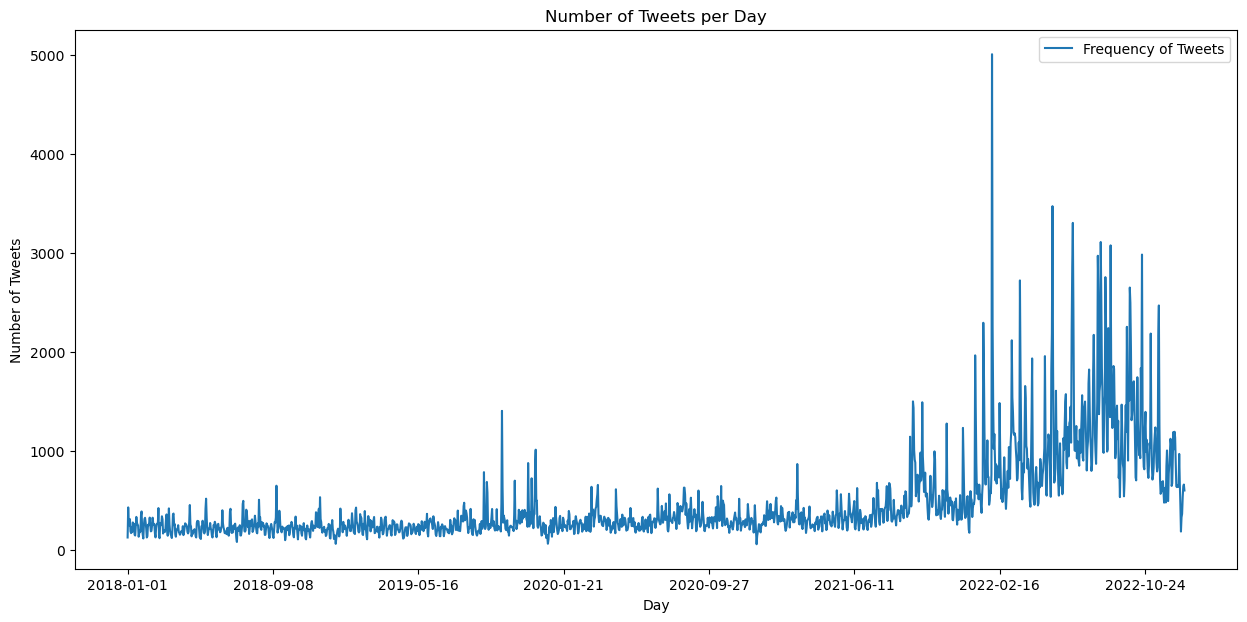

In [ ]:
data_cleaned.groupby('date').count()['userNumTweets'].plot(figsize=(15,7))
plt.legend(['Frequency of Tweets'])
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Day');

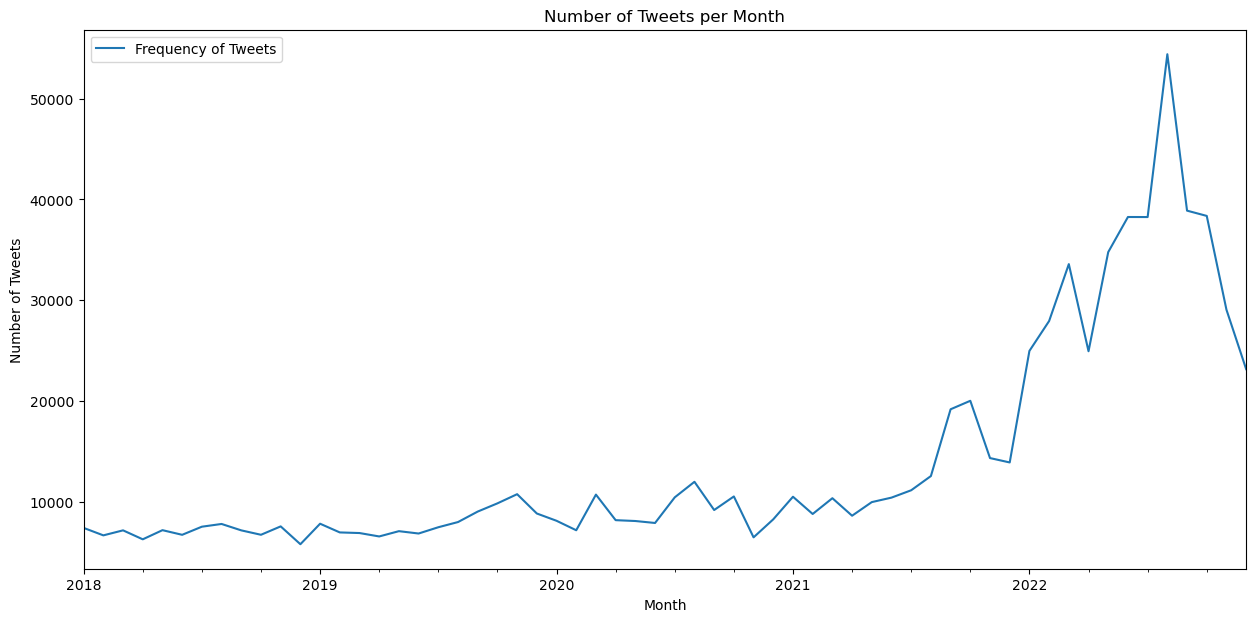

In [ ]:
data_cleaned.groupby('Month').count()['userNumTweets'].plot(figsize=(15,7))
plt.legend(['Frequency of Tweets'])
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Month');

### 2. Analysis of percentages of posts, verified users, users region, and posts generators.

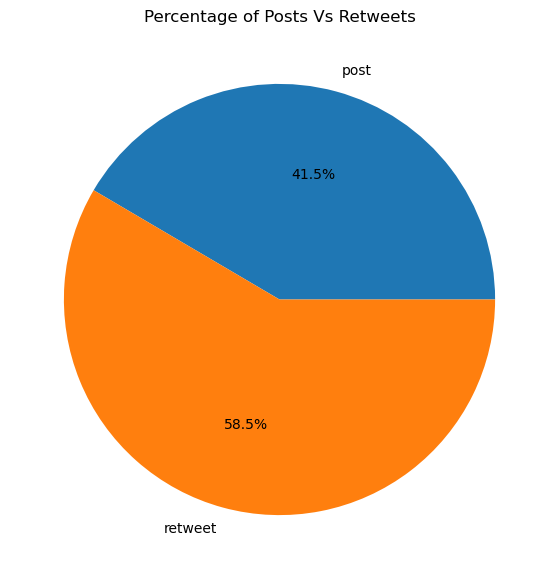

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.groupby('verb').count()['userNumTweets'], labels=['post', 'retweet'], autopct='%1.1f%%')
plt.title('Percentage of Posts Vs Retweets');

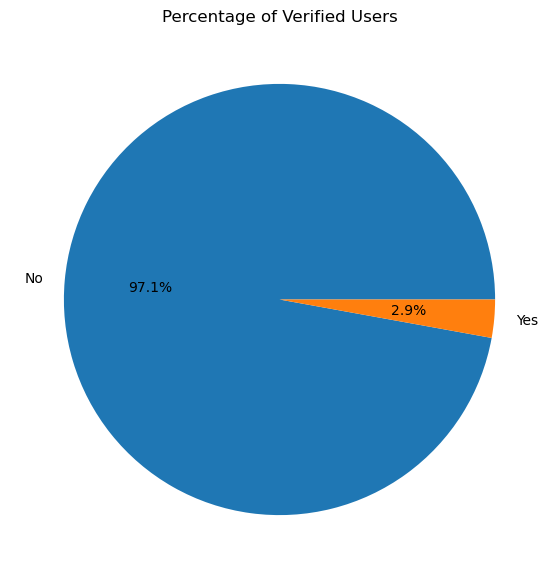

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.groupby('userVerified').count()['userNumTweets'], labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title('Percentage of Verified Users');

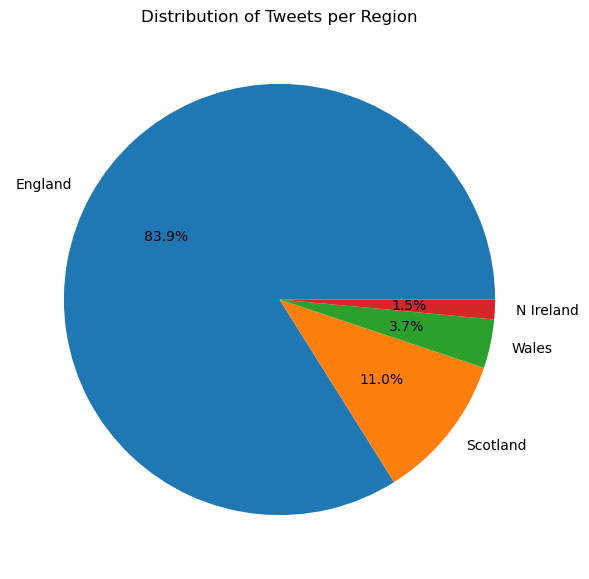

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.region.value_counts().values,
        labels=data_cleaned.region.value_counts().index,
        autopct='%1.1f%%'
       )
plt.title('Distribution of Tweets per Region');

''

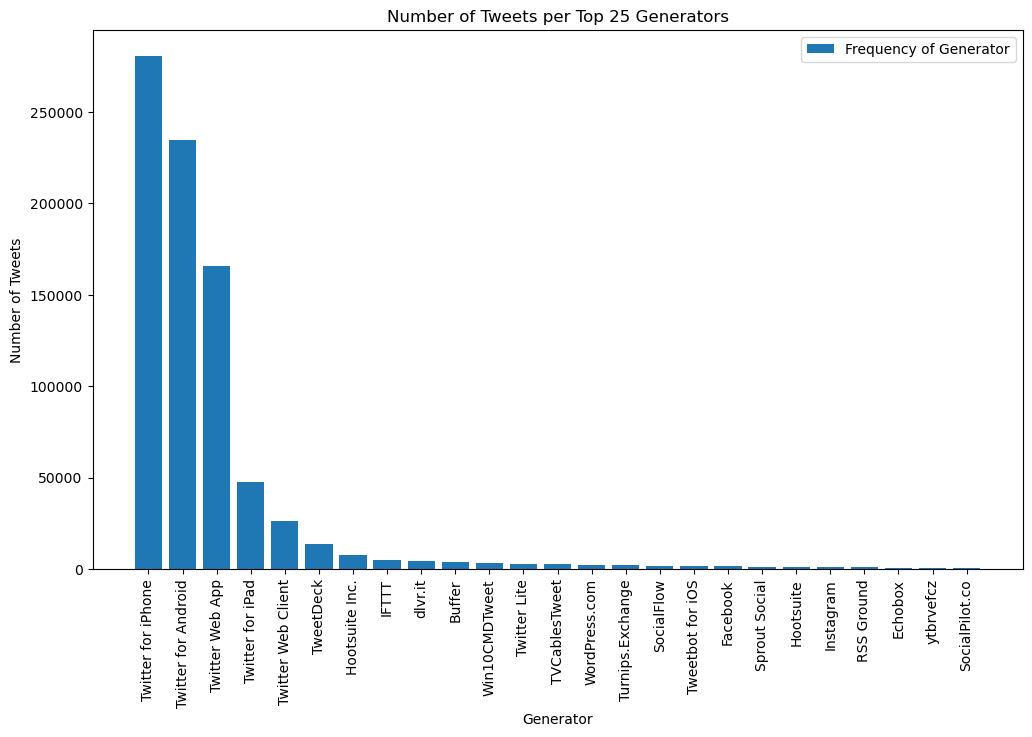

In [ ]:
plt.figure(figsize=(12,7))
attribute = data_cleaned.generator.value_counts()[:25]
plt.bar(range(len(attribute)), attribute.values)
plt.xticks(range(len(attribute)), attribute.index, rotation=90)
plt.legend(['Frequency of Generator'])
plt.title('Number of Tweets per Top 25 Generators')
plt.xlabel('Generator')
plt.ylabel('Number of Tweets')
;

### 3. Sentiment distribution for all tweets, inlfation tweets, and professional tweets.

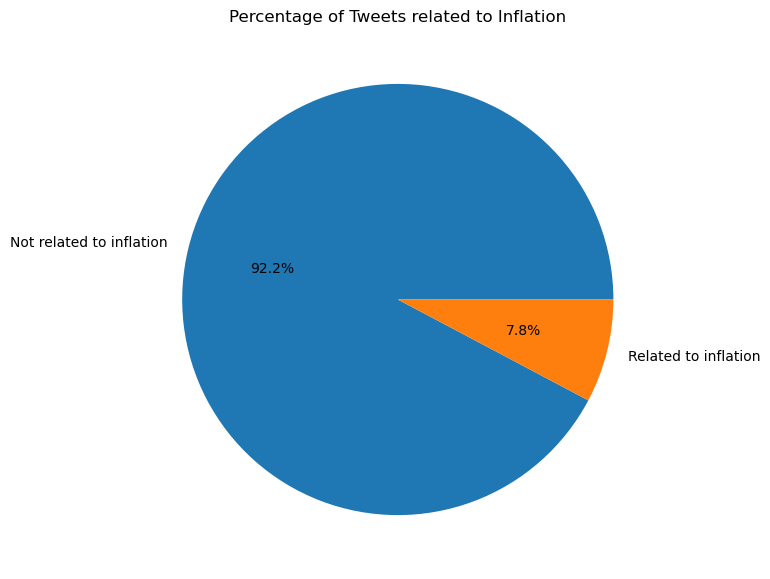

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.inflation_related.value_counts().values,
        labels=['Not related to inflation', 'Related to inflation'],
        autopct='%1.1f%%'
       )
plt.title('Percentage of Tweets related to Inflation');

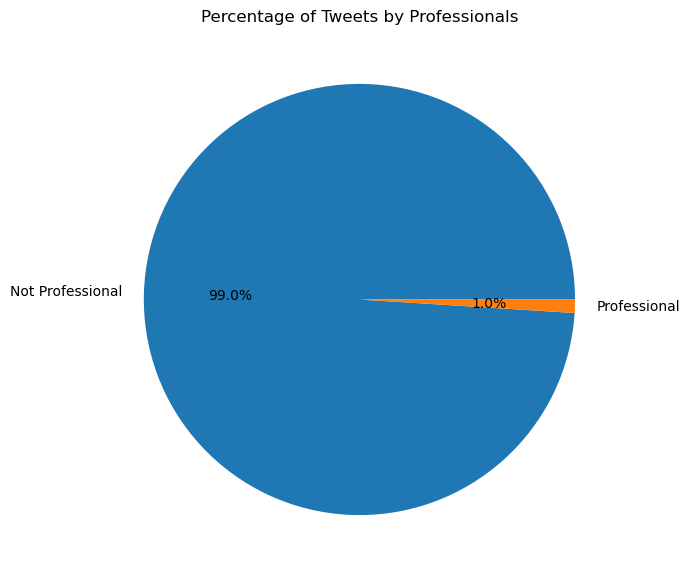

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.is_inflationProfessional.value_counts().values,
        labels=['Not Professional', 'Professional'],
        autopct='%1.1f%%'
       )
plt.title('Percentage of Tweets by Professionals');

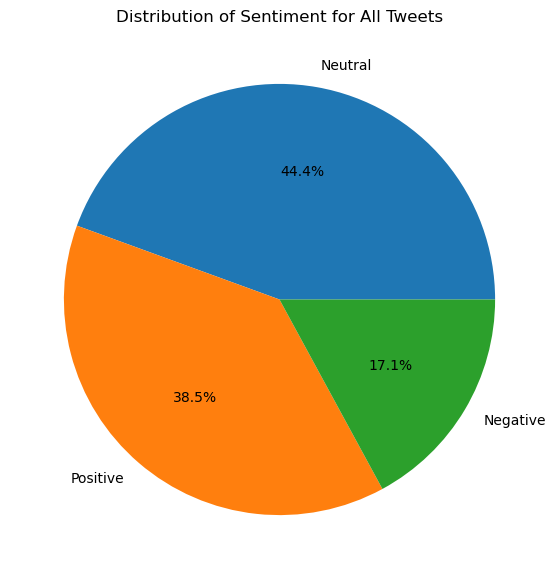

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.sentiment.value_counts().values,
        labels=data_cleaned.sentiment.value_counts().index,
        autopct='%1.1f%%'
       )
plt.title('Distribution of Sentiment for All Tweets');

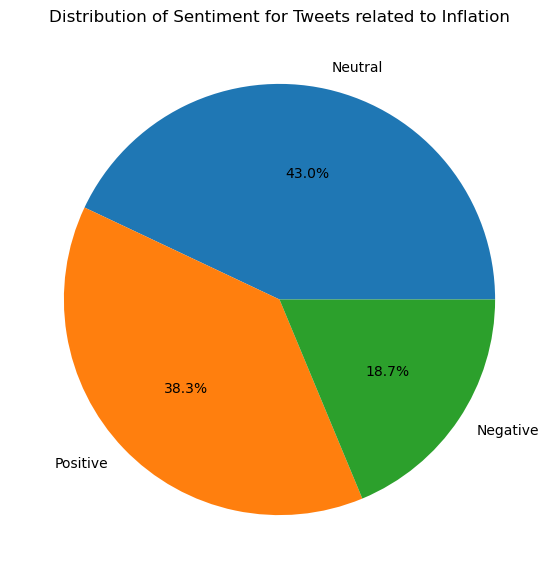

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned_inflation.sentiment.value_counts().values,
        labels=data_cleaned_inflation.sentiment.value_counts().index,
        autopct='%1.1f%%'
       )
plt.title('Distribution of Sentiment for Tweets related to Inflation');

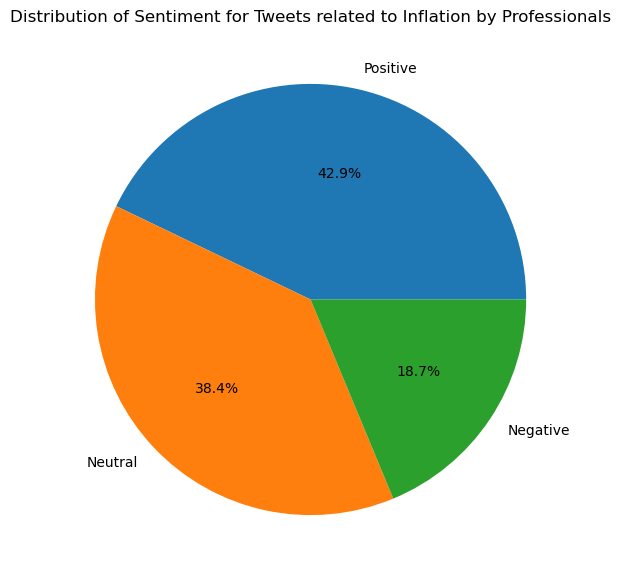

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned_inflation_prof.sentiment.value_counts().values,
        labels=data_cleaned_inflation_prof.sentiment.value_counts().index,
        autopct='%1.1f%%'
       )
plt.title('Distribution of Sentiment for Tweets related to Inflation by Professionals');

### 4. Aggregation of sentiment score per day and per month.

In [ ]:
def checkSentiment(x):
    if x['sentiment'] == 'Positive':
        return x['sentiment_score'], 0
    if x['sentiment'] == 'Negative':
        return 0, x['sentiment_score']
    if x['sentiment'] == 'Neutral':
        return 0, 0

def plotSentimentDaily(data, plt_title):
    data.groupby('date').sum()['sentiment_score'].plot(figsize=(15,7), legend=True);
    plt.ylabel('Sentiment Score')
    plt.title(f'Sum of Compound Sentiment Score of {plt_title} per Day')
    plt.show()

    data.groupby('date').mean()['sentiment_score'].plot(figsize=(15,7), legend=True);
    plt.ylabel('Sentiment Score')
    plt.title(f'Mean of Compound Sentiment Score of {plt_title} per Day')
    plt.show()


    dummy = pd.DataFrame()
    dummy['date'] = data['date']
    dummy[['Positive', 'Negative']] = data.apply(lambda x: checkSentiment(x), axis=1).apply(pd.Series)
    dummy.groupby('date').sum().plot(figsize=(15,7))
    plt.ylabel('Sentiment Score')
    plt.title(f'Sum of +Ve and -Ve Sentiment Scores of {plt_title} per Day')
    plt.show()

    dummy.groupby('date').mean().plot(figsize=(15,7))
    plt.ylabel('Sentiment Score')
    plt.title(f'Mean of +Ve and -Ve Sentiment Scores of {plt_title} per Day')
    plt.show()


def plotSentimentMonthly(data, plt_title):
    data.groupby('Month').sum()['sentiment_score'].plot(figsize=(15,7), legend=True);
    plt.ylabel('Sentiment Score')
    plt.title(f'Sum of Compound Sentiment Score of {plt_title} per Month')
    plt.show()

    data.groupby('Month').mean()['sentiment_score'].plot(figsize=(15,7), legend=True);
    plt.ylabel('Sentiment Score')
    plt.title(f'Mean of Compound Sentiment Score of {plt_title} per Month')
    plt.show()


    dummy = pd.DataFrame()
    dummy['Month'] = data['Month']
    dummy[['Positive', 'Negative']] = data.apply(lambda x: checkSentiment(x), axis=1).apply(pd.Series)
    dummy.groupby('Month').sum().plot(figsize=(15,7))
    plt.ylabel('Sentiment Score')
    plt.title(f'Sum of +Ve and -Ve Sentiment Scores of {plt_title}per Month')
    plt.show()

    dummy.groupby('Month').mean().plot(figsize=(15,7))
    plt.ylabel('Sentiment Score')
    plt.title(f'Mean of +Ve and -Ve Sentiment Scores of {plt_title} per Month')
    plt.show()

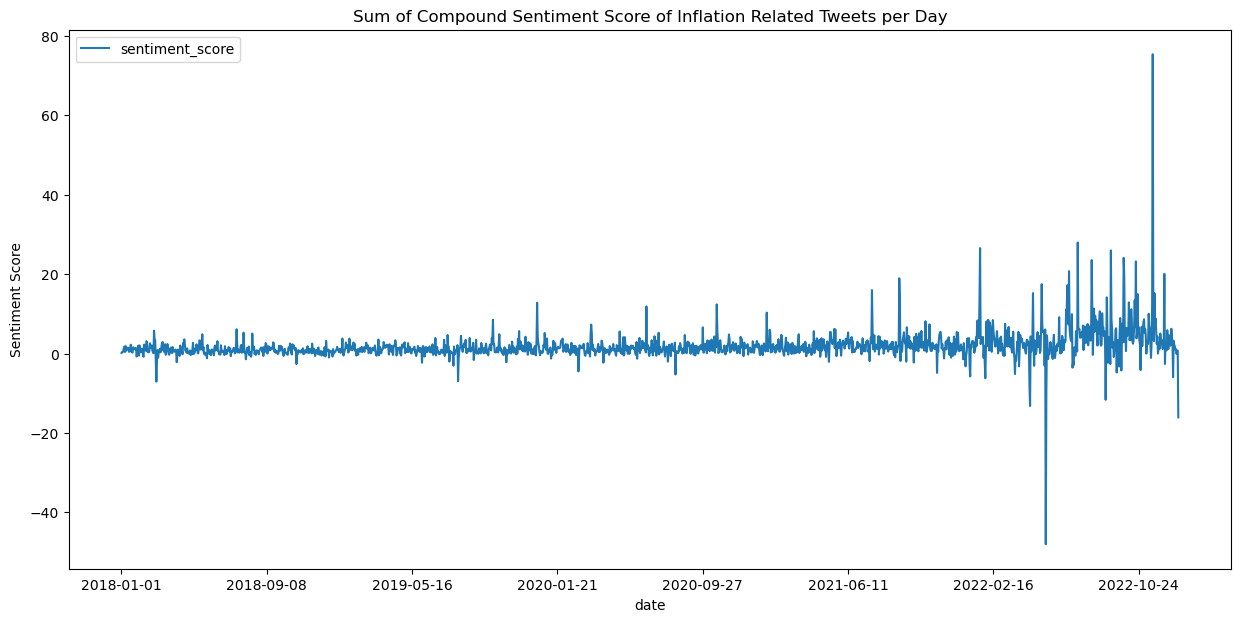

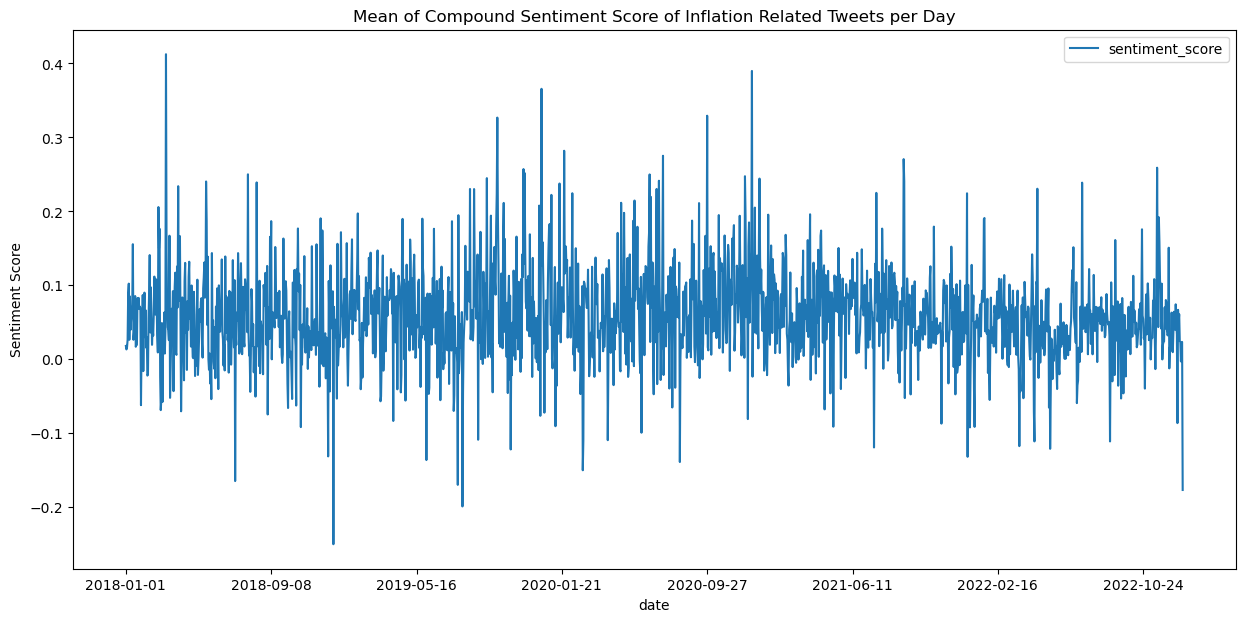

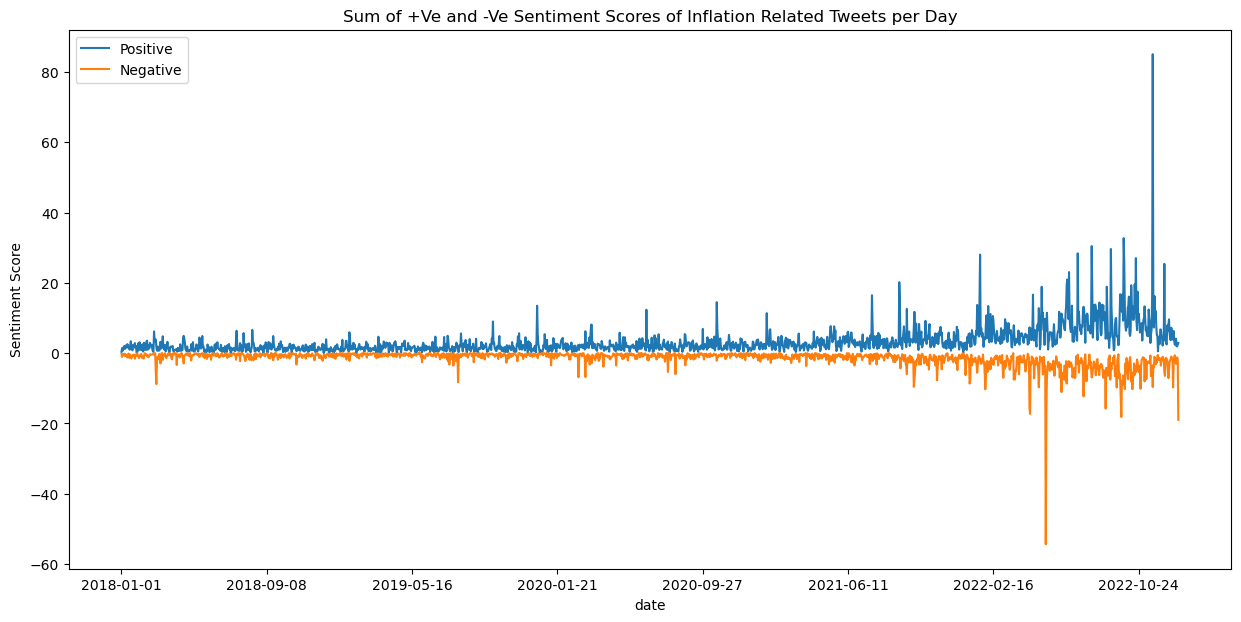

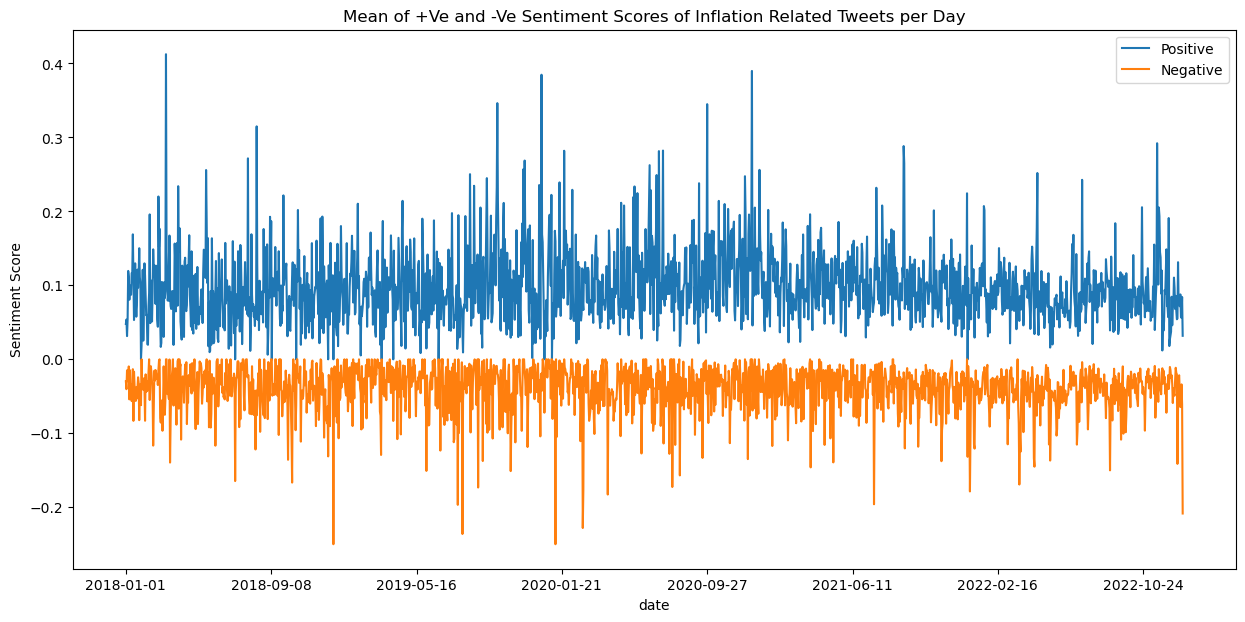

In [ ]:
plotSentimentDaily(data_cleaned_inflation, 'Inflation Related Tweets')

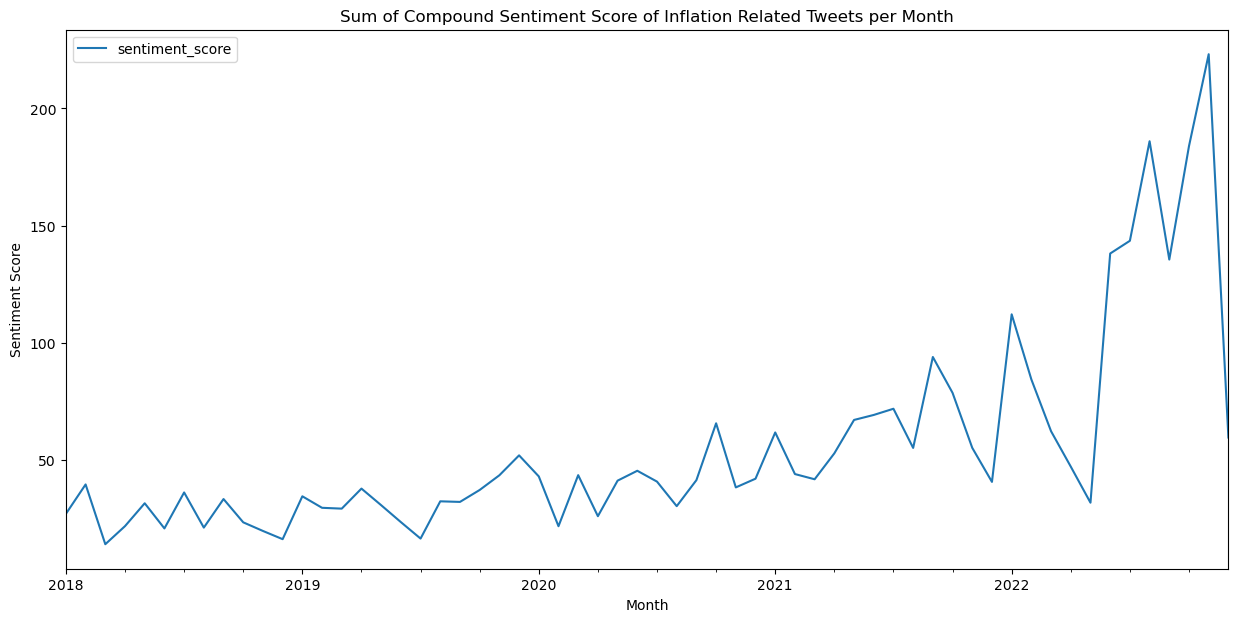

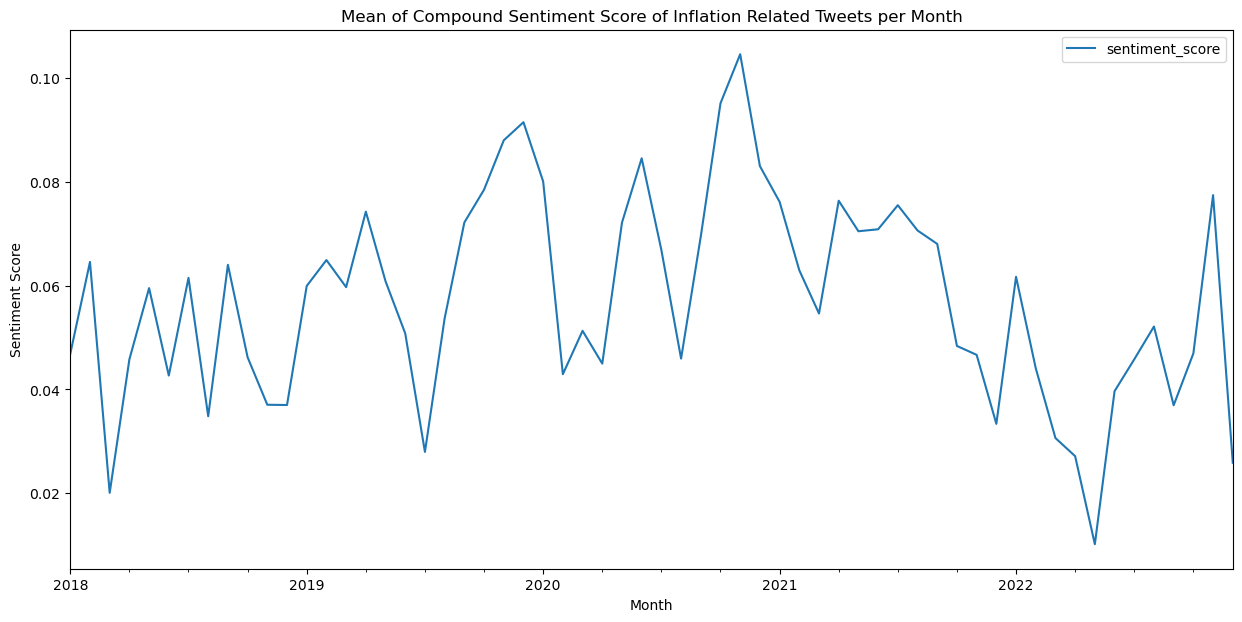

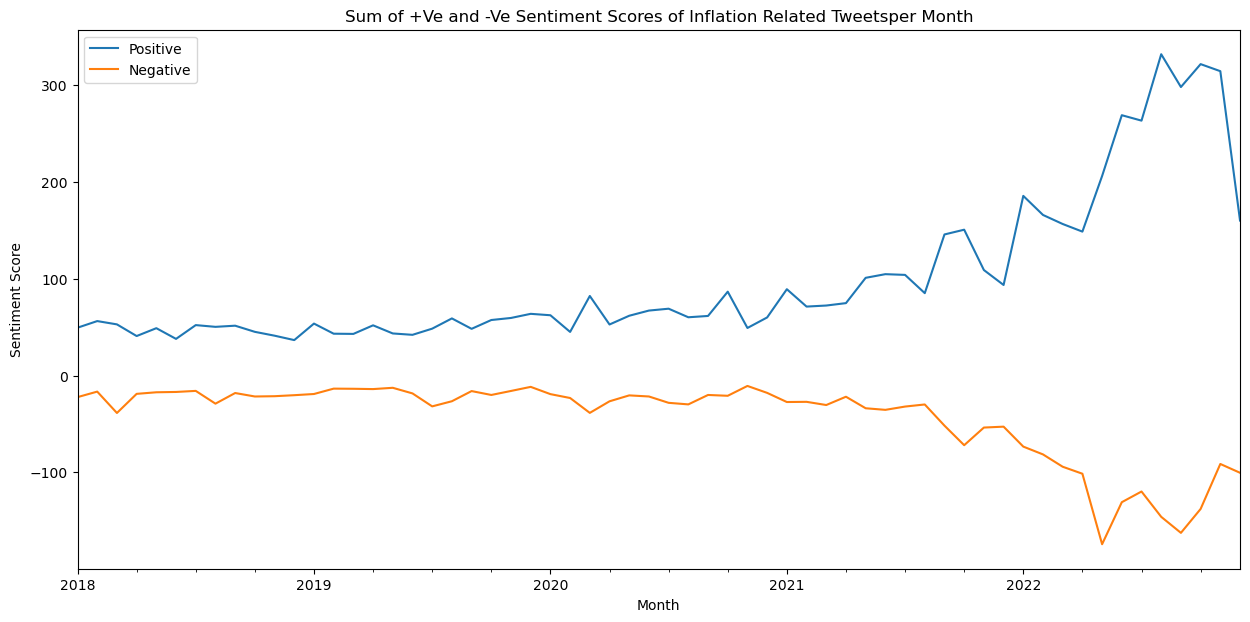

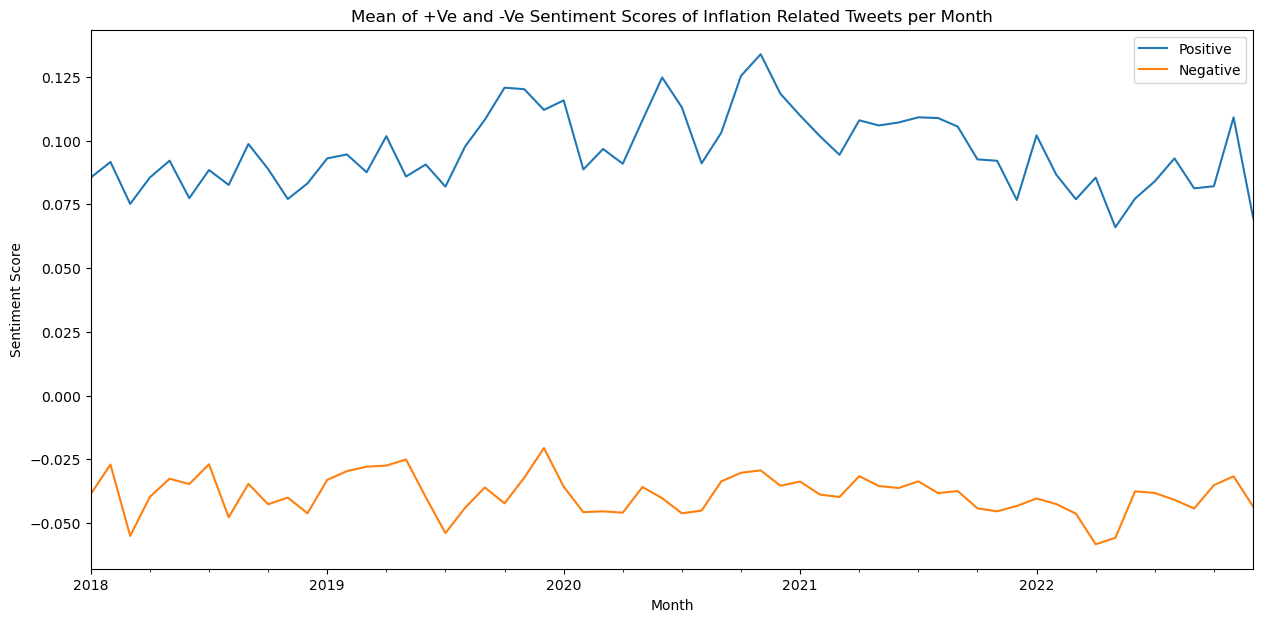

In [ ]:
plotSentimentMonthly(data_cleaned_inflation, 'Inflation Related Tweets')

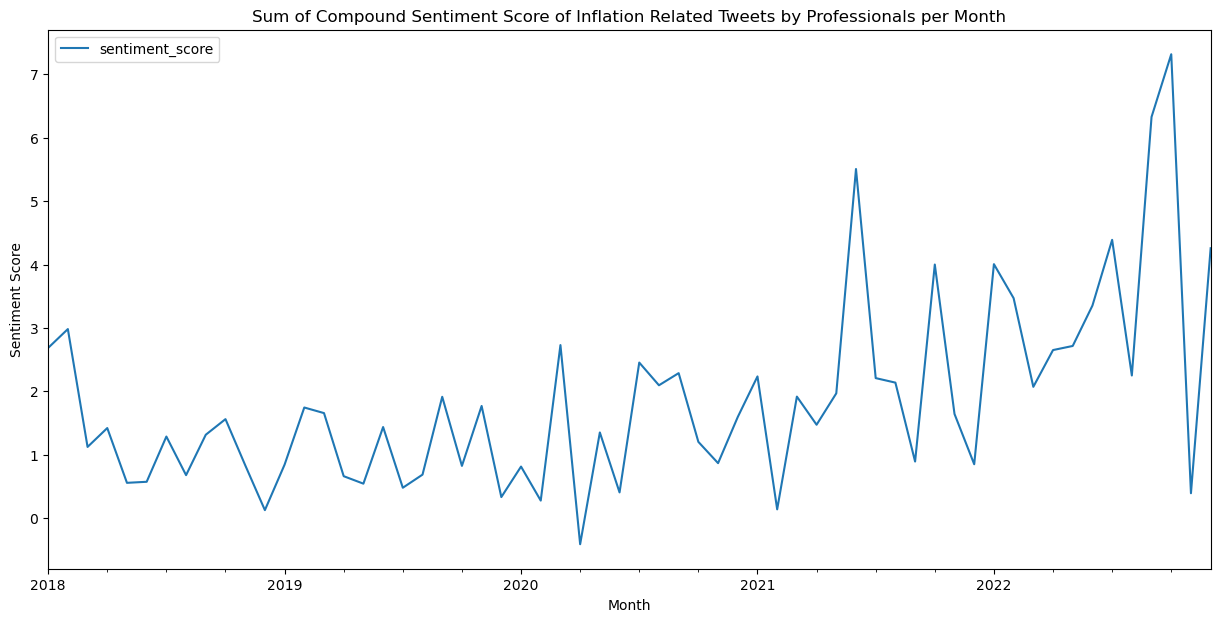

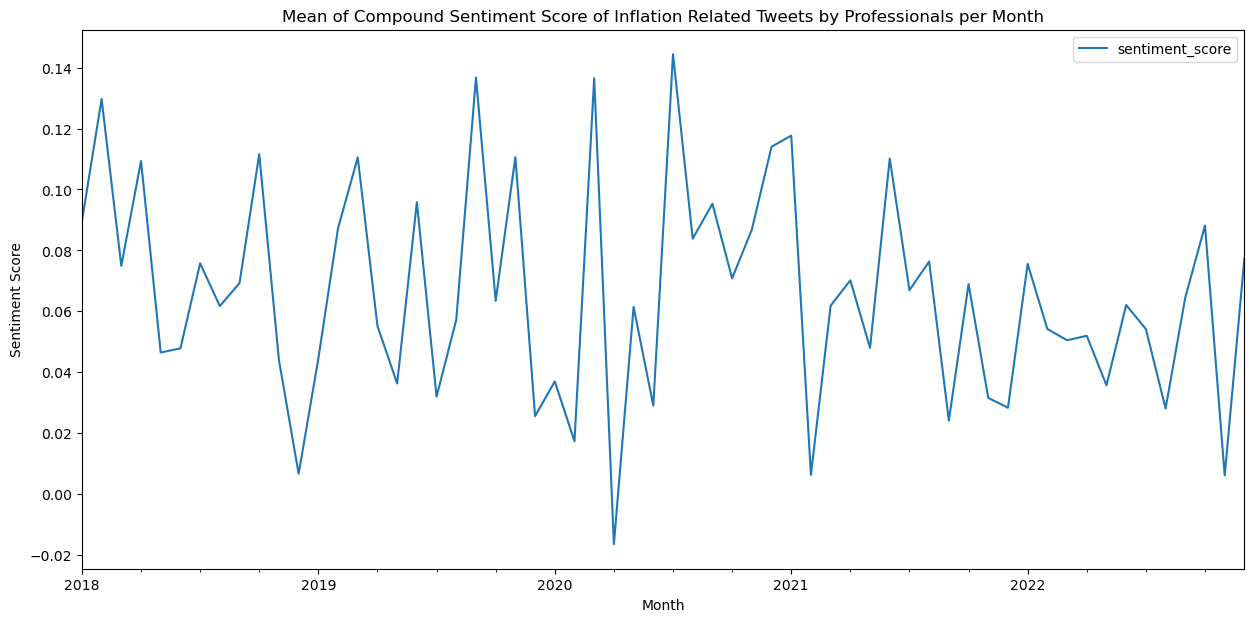

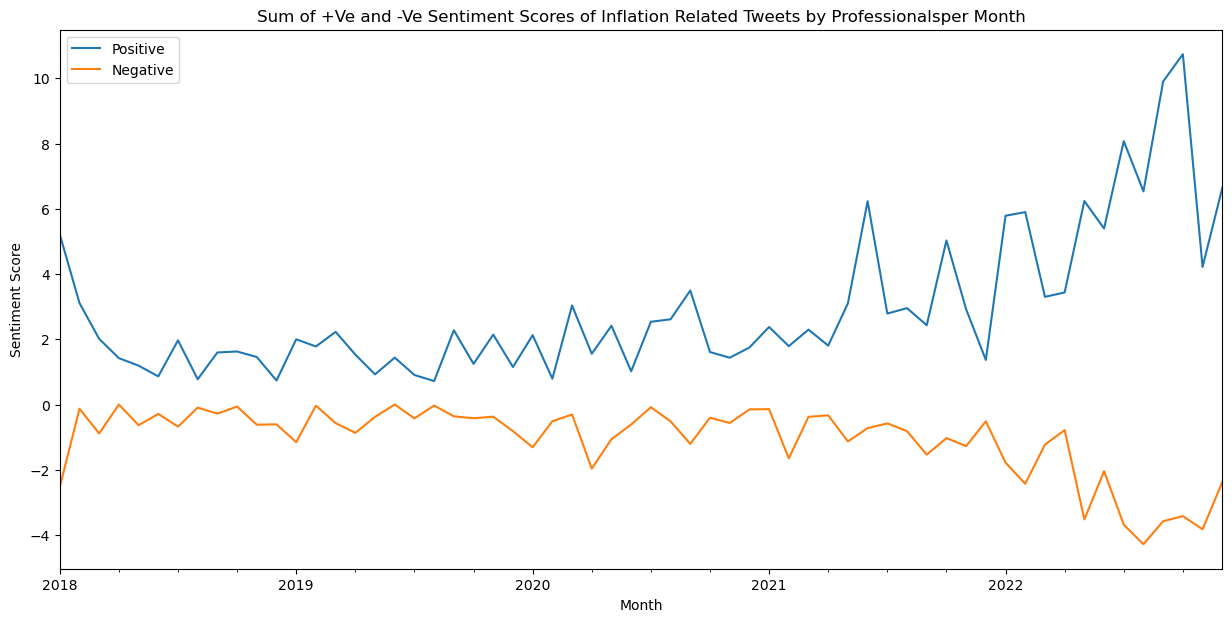

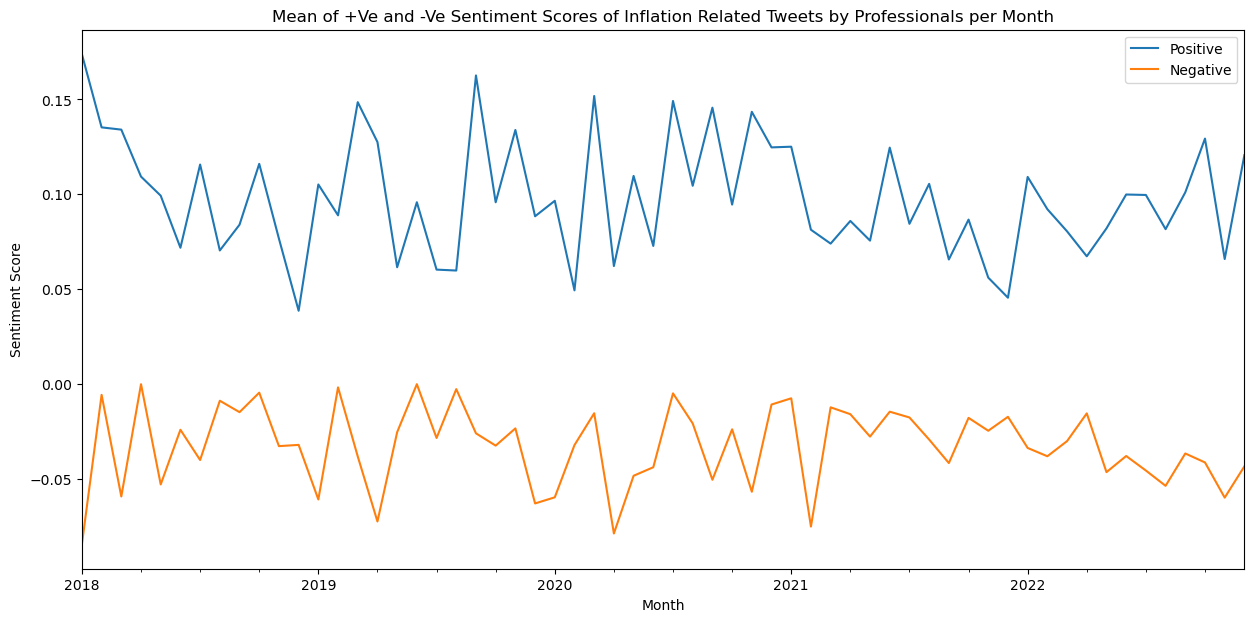

In [ ]:
plotSentimentMonthly(data_cleaned_inflation_prof, 'Inflation Related Tweets by Professionals')

## Building indicators

In [ ]:
indicators_df = pd.DataFrame()
indicators_df['Month'] = data_cleaned.Month.unique()
indicators_df['Month'] = pd.to_datetime(indicators_df['Month'])
indicators_df = indicators_df.set_index('Month')

In [ ]:
indicators_df['countOfAllTweets'] = data_cleaned.groupby('Month').count()['userNumTweets'].values

indicators_df['sumOfCompoundSentimentForAllTweets'] = data_cleaned.groupby('Month').sum()['sentiment_score'].values
indicators_df['sumOf+veSentimentForAllTweets'] = data_cleaned[data_cleaned.sentiment=='Positive'].groupby('Month').sum()['sentiment_score'].values
indicators_df['sumOf-veSentimentForAllTweets'] = data_cleaned[data_cleaned.sentiment=='Negative'].groupby('Month').sum()['sentiment_score'].values

indicators_df['meanOfCompoundSentimentForAllTweets'] = data_cleaned.groupby('Month').mean()['sentiment_score'].values
indicators_df['meanOf+veSentimentForAllTweets'] = data_cleaned[data_cleaned.sentiment=='Positive'].groupby('Month').mean()['sentiment_score'].values
indicators_df['meanOf-veSentimentForAllTweets'] = data_cleaned[data_cleaned.sentiment=='Negative'].groupby('Month').mean()['sentiment_score'].values

In [ ]:
indicators_df['countOfInflationTweets'] = data_cleaned_inflation.groupby('Month').count()['sentiment'].values

indicators_df['sumOfCompoundSentimentForInflationTweets'] = data_cleaned_inflation.groupby('Month').sum()['sentiment_score'].values
indicators_df['sumOf+veSentimentForInflationTweets'] = data_cleaned_inflation[data_cleaned_inflation.sentiment == 'Positive'].groupby('Month').sum()['sentiment_score'].values
indicators_df['sumOf-veSentimentForInflationTweets'] = data_cleaned_inflation[data_cleaned_inflation.sentiment == 'Negative'].groupby('Month').sum()['sentiment_score'].values

indicators_df['meanOfCompoundSentimentForInflationTweets'] = data_cleaned_inflation.groupby('Month').mean()['sentiment_score'].values
indicators_df['meanOf+veSentimentForInflationTweets'] = data_cleaned_inflation[data_cleaned_inflation.sentiment == 'Positive'].groupby('Month').mean()['sentiment_score'].values
indicators_df['meanOf-veSentimentForInflationTweets'] = data_cleaned_inflation[data_cleaned_inflation.sentiment == 'Negative'].groupby('Month').mean()['sentiment_score'].values

In [ ]:
indicators_df['countOfProfessionalsTweets'] = data_cleaned_prof.groupby('Month').count()['sentiment'].values

indicators_df['sumOfCompoundSentimentForProfessionalsTweets'] = data_cleaned_prof.groupby('Month').sum()['sentiment_score'].values
indicators_df['sumOf+veSentimentForProfessionalsTweets'] = data_cleaned_prof[data_cleaned_prof.sentiment == 'Positive'].groupby('Month').sum()['sentiment_score'].values
indicators_df['sumOf-veSentimentForProfessionalsTweets'] = data_cleaned_prof[data_cleaned_prof.sentiment == 'Negative'].groupby('Month').sum()['sentiment_score'].values


indicators_df['meanOfCompoundSentimentForProfessionalsTweets'] = data_cleaned_prof.groupby('Month').mean()['sentiment_score'].values
indicators_df['meanOf+veSentimentForProfessionalsTweets'] = data_cleaned_prof[data_cleaned_prof.sentiment == 'Positive'].groupby('Month').mean()['sentiment_score'].values
indicators_df['meanOf-veSentimentForProfessionalsTweets'] = data_cleaned_prof[data_cleaned_prof.sentiment == 'Negative'].groupby('Month').mean()['sentiment_score'].values

In [ ]:
indicators_df['countOfProfessionalsInflationTweets'] = data_cleaned_inflation_prof.groupby('Month').count()['sentiment'].values

indicators_df['sumOfCompoundSentimentForProfessionalsInflationTweets'] = data_cleaned_inflation_prof.groupby('Month').sum()['sentiment_score'].values
indicators_df['sumOf+veSentimentForProfessionalsInflationTweets'] = data_cleaned_inflation_prof[data_cleaned_inflation_prof.sentiment == 'Positive'].groupby('Month').sum()['sentiment_score'].values
temp = data_cleaned_inflation_prof[data_cleaned_inflation_prof.sentiment == 'Negative'].groupby('Month').sum()['sentiment_score']
indicators_df.loc[temp.index, 'sumOf-veSentimentForProfessionalsInflationTweets'] = temp.values


indicators_df['meanOfCompoundSentimentForProfessionalsInflationTweets'] = data_cleaned_inflation_prof.groupby('Month').mean()['sentiment_score'].values
indicators_df['meanOf+veSentimentForProfessionalsInflationTweets'] = data_cleaned_inflation_prof[data_cleaned_inflation_prof.sentiment == 'Positive'].groupby('Month').mean()['sentiment_score'].values
temp = data_cleaned_inflation_prof[data_cleaned_inflation_prof.sentiment == 'Negative'].groupby('Month').mean()['sentiment_score']
indicators_df.loc[temp.index, 'meanOf-veSentimentForProfessionalsInflationTweets'] = temp.values

indicators_df = indicators_df.fillna(indicators_df.mean())

## Frequencies

### 1. Bag of Words

In [ ]:
from wordcloud import WordCloud

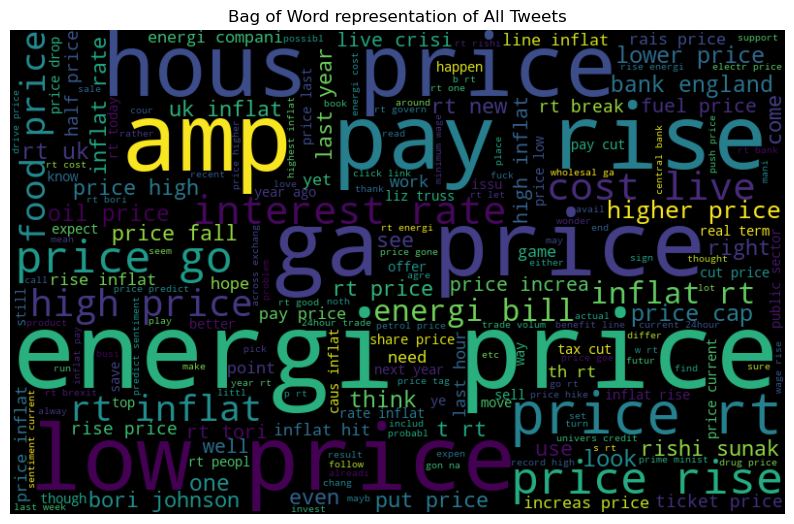

In [ ]:
# Combine the processed tweets into a single string
combined_tweets = ' '.join(data_cleaned['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Bag of Word representation of All Tweets')
plt.show()

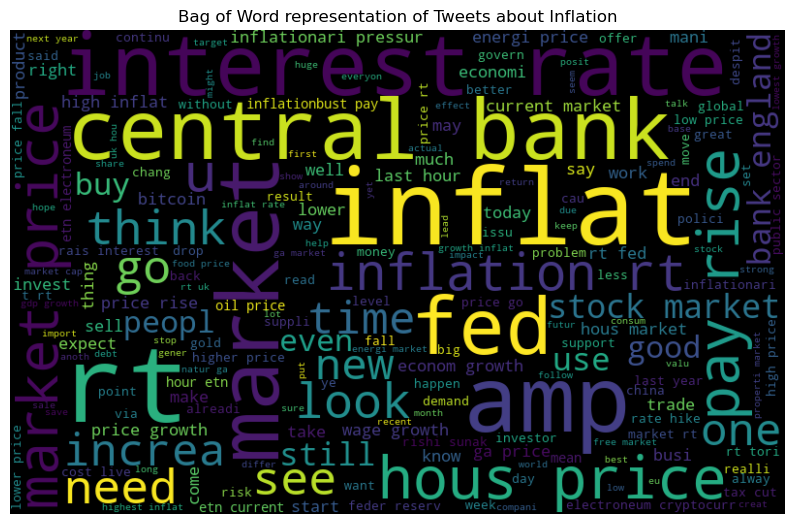

In [ ]:
# Combine the processed tweets into a single string
combined_tweets = ' '.join(data_cleaned_inflation['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Bag of Word representation of Tweets about Inflation')
plt.show()

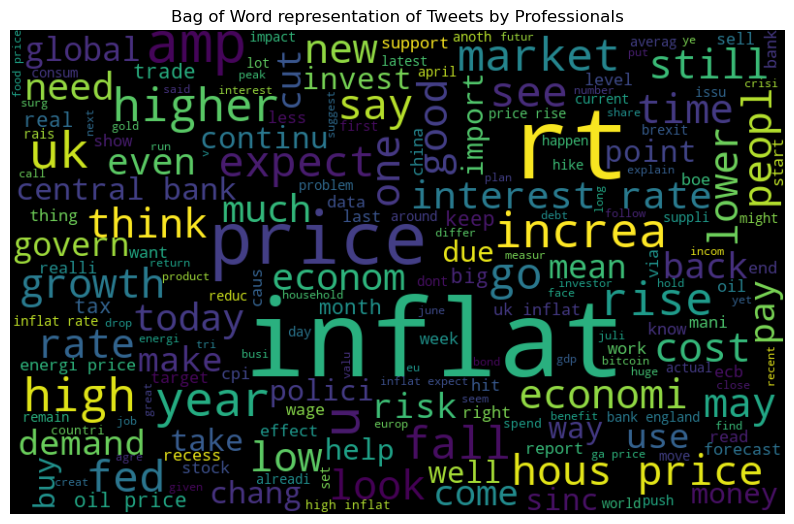

In [ ]:
# Combine the processed tweets into a single string
combined_tweets = ' '.join(data_cleaned_prof['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Bag of Word representation of All Tweets by Professionals')
plt.show()

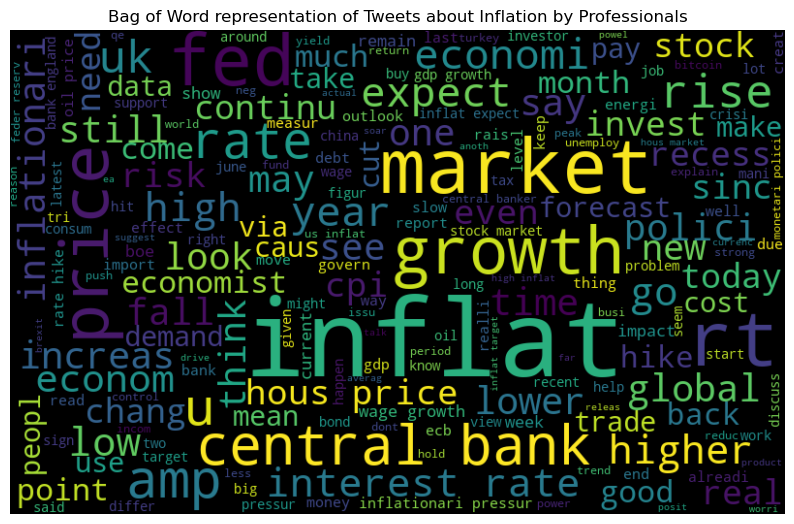

In [ ]:
# Combine the processed tweets into a single string
combined_tweets = ' '.join(data_cleaned_inflation_prof['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Bag of Word representation of Tweets about Inflation by Professionals')
plt.show()

In [ ]:
'CPHPTT01GBM659N.csv'
'GBRCPALTT01CTGYM.csv'
'GBRCPIALLMINMEI.csv'
'GBRCPIENGMINMEI.csv'

### 2. Grams

#### 2.1  Unigrams Distribution

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [ ]:
common_words = get_top_n_words(data_cleaned['processed_tweet'] , 20)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [ ]:
allTweetsTop15Unigrams = unigram.drop(index=unigram.loc[unigram['unigram']=='rt',].index)
allTweetsTop15Unigrams = allTweetsTop15Unigrams.drop(index=allTweetsTop15Unigrams.loc[allTweetsTop15Unigrams['unigram']=='amp',].index)
allTweetsTop15Unigrams = allTweetsTop15Unigrams.reset_index(drop=True).iloc[:15].unigram.to_list()

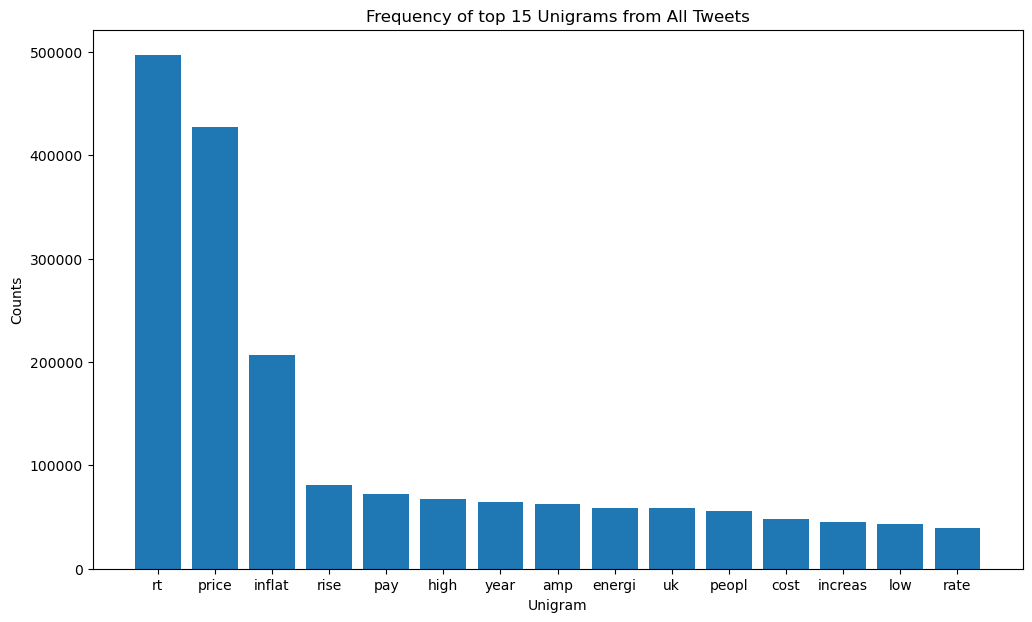

In [ ]:
unigram = unigram.iloc[:15]
plt.figure(figsize=(12,7))
plt.bar(x = unigram['unigram'], height = unigram['count'] )
plt.title('Frequency of top 15 Unigrams from All Tweets')
plt.ylabel('Counts')
plt.xlabel('Unigram');

In [ ]:
common_words = get_top_n_words(data_cleaned_inflation['processed_tweet'] , 16)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [ ]:
inflationTweetsTop15Unigrams = unigram.drop(index=unigram.loc[unigram['unigram']=='rt',].index)
inflationTweetsTop15Unigrams = inflationTweetsTop15Unigrams.drop(index=inflationTweetsTop15Unigrams.loc[inflationTweetsTop15Unigrams['unigram']=='amp',].index)
inflationTweetsTop15Unigrams = inflationTweetsTop15Unigrams.reset_index(drop=True).iloc[:15].unigram.to_list()

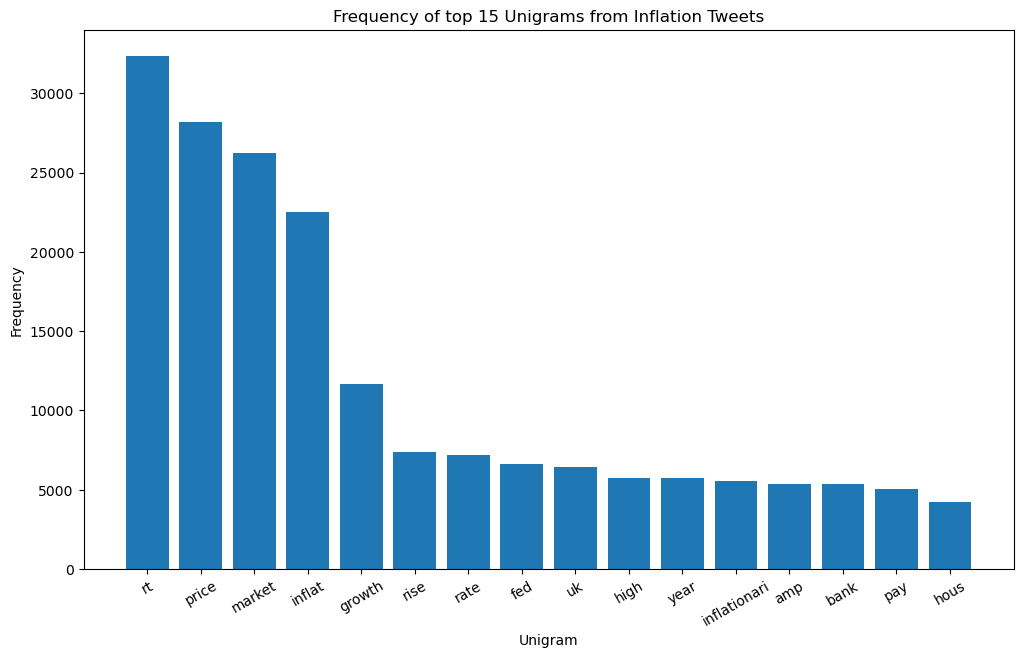

In [ ]:
plt.figure(figsize=(12,7))
plt.bar(x = unigram['unigram'], height = unigram['count'])
plt.title('Frequency of top 15 Unigrams from Inflation Tweets')
plt.ylabel('Frequency')
plt.xlabel('Unigram')
plt.xticks(rotation=30);

In [ ]:
common_words = get_top_n_words(data_cleaned_inflation_prof['processed_tweet'], 16)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [ ]:
inflationProfessionalTweetsTop15Unigrams = unigram.drop(index=unigram.loc[unigram['unigram']=='rt',].index)
inflationProfessionalTweetsTop15Unigrams = inflationProfessionalTweetsTop15Unigrams.drop(index=inflationProfessionalTweetsTop15Unigrams.loc[inflationProfessionalTweetsTop15Unigrams['unigram']=='amp',].index)
inflationProfessionalTweetsTop15Unigrams = inflationProfessionalTweetsTop15Unigrams.reset_index(drop=True).iloc[:15].unigram.to_list()

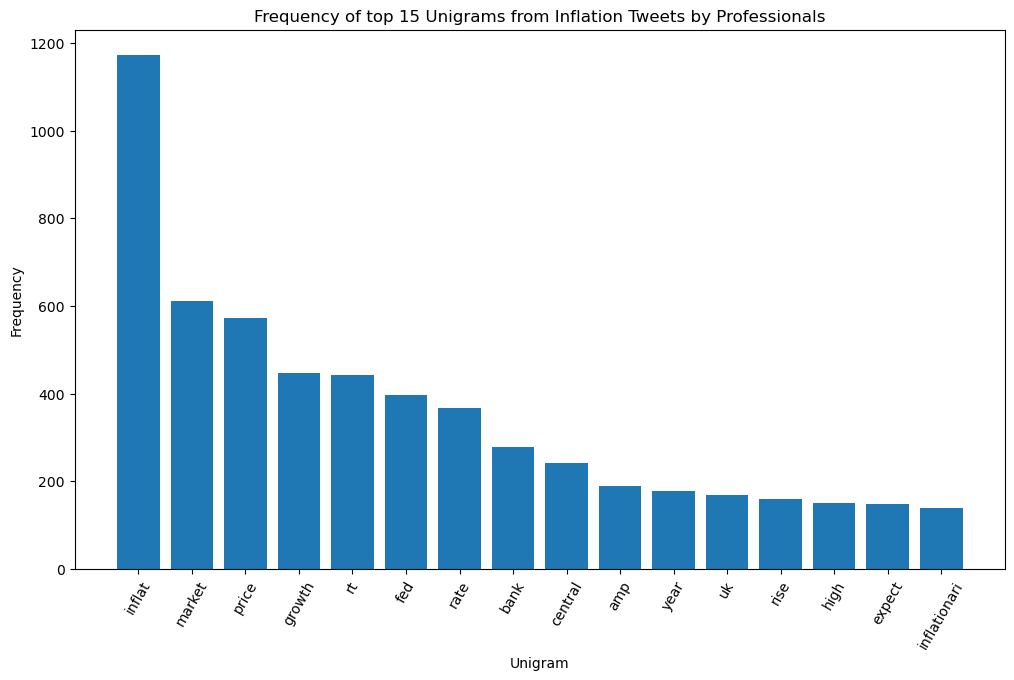

In [ ]:
plt.figure(figsize=(12,7))
plt.bar(x = unigram['unigram'], height = unigram['count'])
plt.title('Frequency of top 15 Unigrams from Inflation Tweets by Professionals')
plt.ylabel('Frequency')
plt.xlabel('Unigram')
plt.xticks(rotation=60);

#### 2.2 Bigrams Distribution

In [ ]:
def get_top_n_bigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(2,2),stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [ ]:
common_words = get_top_n_bigram(data_cleaned['processed_tweet'] , 16)
bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

In [ ]:
allTweetsTop15Bigrams = bigram.iloc[:15].bigram.to_list()

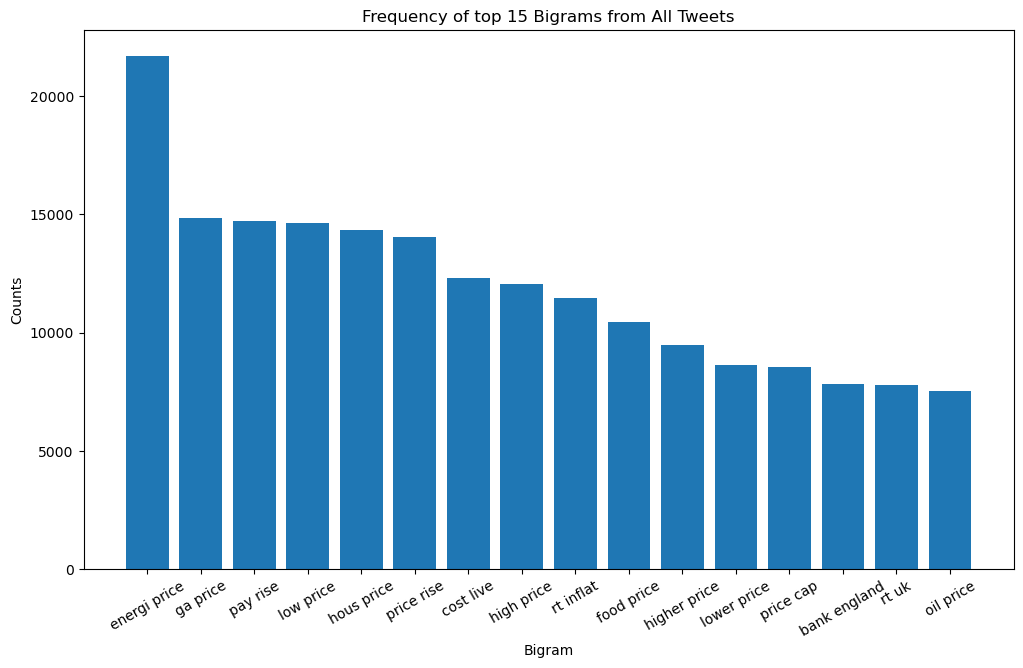

In [ ]:
plt.figure(figsize=(12,7))
plt.bar(x = bigram['bigram'], height = bigram['count'] )
plt.title('Frequency of top 15 Bigrams from All Tweets')
plt.ylabel('Counts')
plt.xlabel('Bigram')
plt.xticks(rotation=30);

In [ ]:
common_words = get_top_n_bigram(data_cleaned_inflation['processed_tweet'] , 16)
bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

In [ ]:
inflationTweetsTop15Bigrams = bigram.iloc[:15].bigram.to_list()

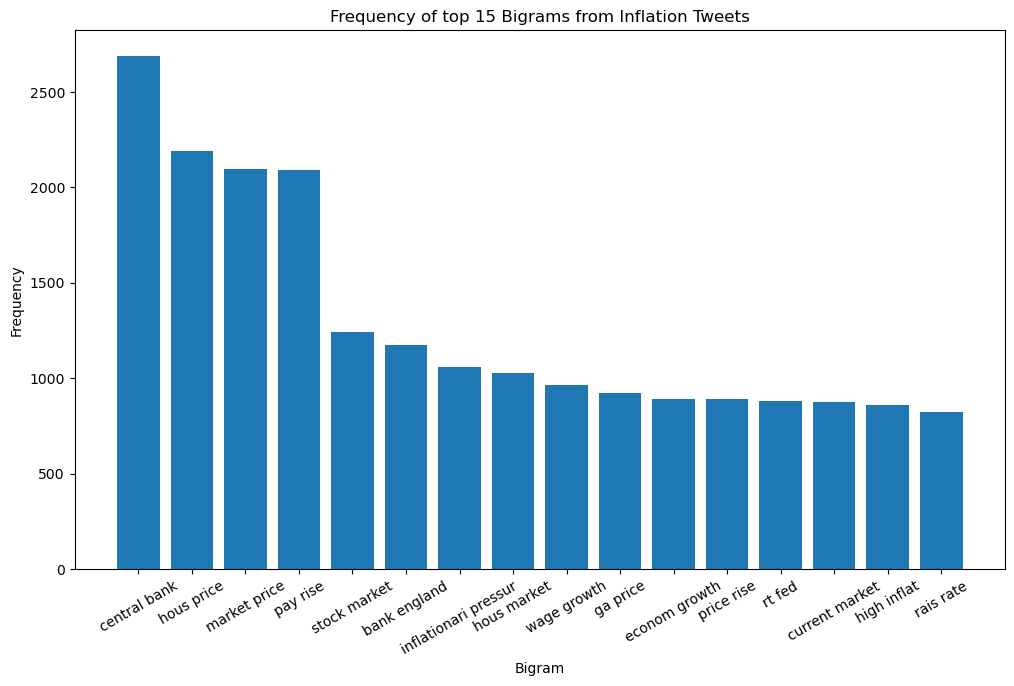

In [ ]:
plt.figure(figsize=(12,7))
plt.bar(x = bigram['bigram'], height = bigram['count'])
plt.title('Frequency of top 15 Bigrams from Inflation Tweets')
plt.ylabel('Frequency')
plt.xlabel('Bigram')
plt.xticks(rotation=30);

In [ ]:
common_words = get_top_n_bigram(data_cleaned_inflation_prof['processed_tweet'], 16)
bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

In [ ]:
inflationProfessionalTweetsTop15Bigrams = bigram.iloc[:15].bigram.to_list()

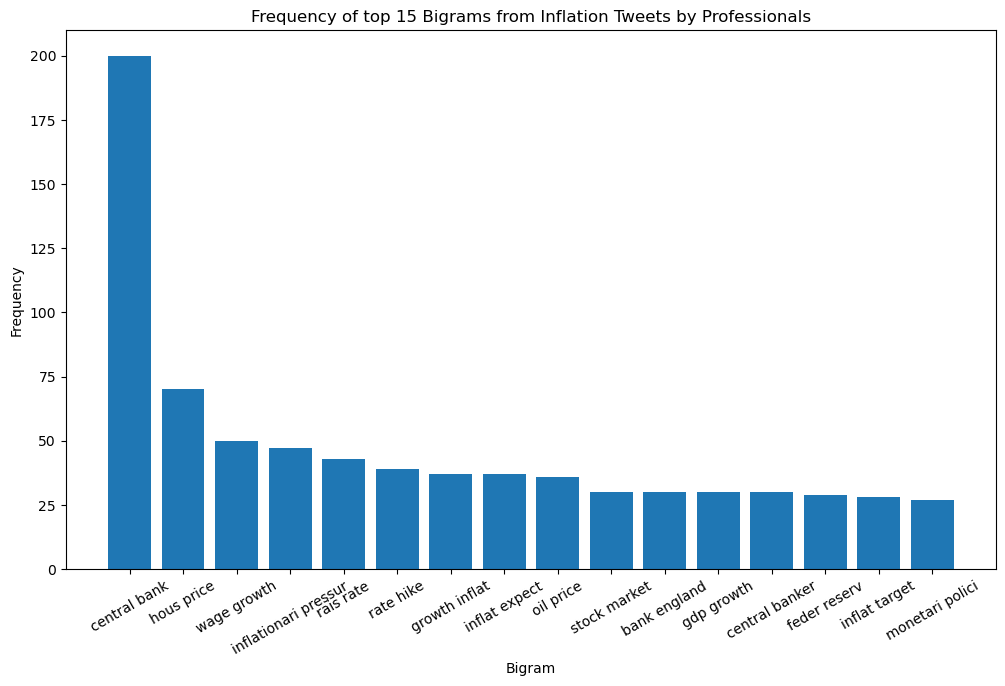

In [ ]:
plt.figure(figsize=(12,7))
plt.bar(x = bigram['bigram'], height = bigram['count'])
plt.title('Frequency of top 15 Bigrams from Inflation Tweets by Professionals')
plt.ylabel('Frequency')
plt.xlabel('Bigram')
plt.xticks(rotation=30);

#### 2.3 Trigram Distribution

In [ ]:
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(3,3),stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [ ]:
common_words = get_top_n_trigram(data_cleaned['processed_tweet'], 100)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [ ]:
listToRemove = [
 '24hour trade volum',
 'price predict sentiment',
 'predict sentiment current',
 'rt bori johnson',
 'rt rishi sunak',
 'pleas click link',
 'click link origin',
 'bell pleas click',
 'link origin tweet',
 'origin tweet join',
 'rt went cinema',
 'went cinema yest',
 'cinema yest 845pm',
 'yest 845pm 917',
 '845pm 917 film',
 '917 film actual',
 'film actual start',
 'actual start cinema',
 'start cinema pay',
 'cinema pay films',
 'public sector worker',
 'rt liz truss',
 'rt woke morn',
 'woke morn radio',
 'morn radio talk',
 'radio talk cost',
]

In [ ]:
temp = trigram.drop(index=trigram[trigram['trigram'].apply(lambda x: any([k == x for k in listToRemove]))].index).reset_index(drop=True)
allTweetsTop15Trigrams = temp.iloc[:15].trigram.to_list()

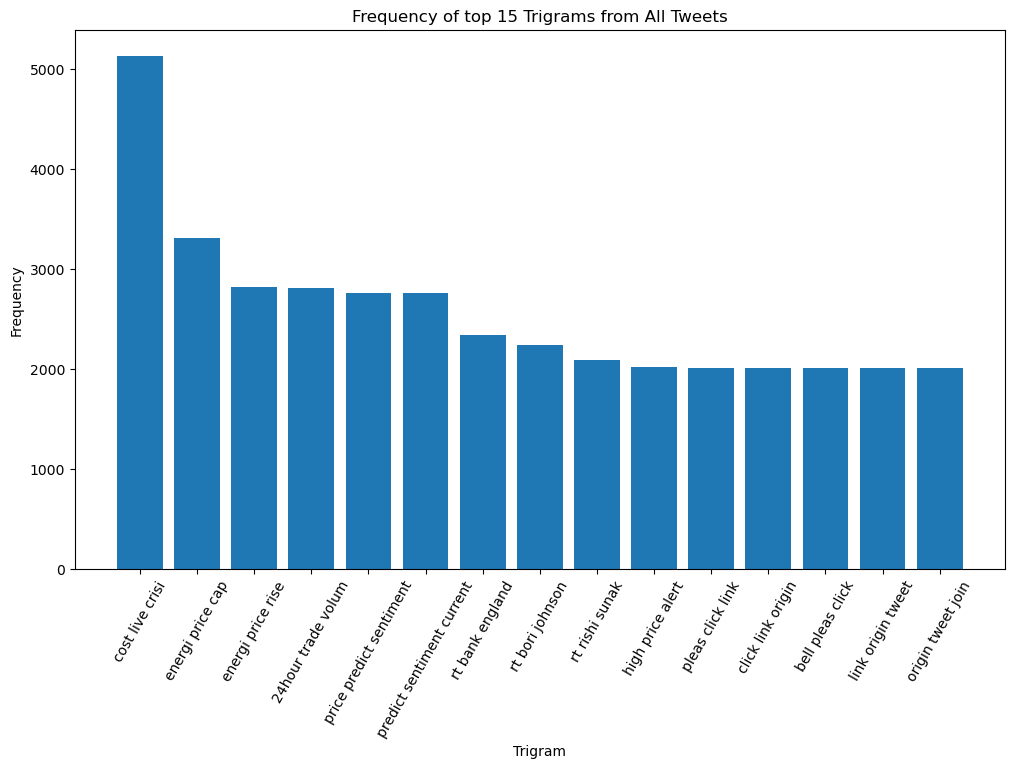

In [ ]:
trigram = trigram.iloc[:15]
plt.figure(figsize=(12,7))
plt.bar(x = trigram['trigram'], height = trigram['count'])
plt.title('Frequency of top 15 Trigrams from All Tweets')
plt.ylabel('Frequency')
plt.xlabel('Trigram')
plt.xticks(rotation=60);

In [ ]:
common_words = get_top_n_trigram(data_cleaned_inflation['processed_tweet'], 100)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [ ]:
listToRemove = [
 'hour etn electroneum',
 'etn electroneum cryptocurr',
 'rt someth odd',
 'someth odd afoot',
 'odd afoot natur',
]

In [ ]:
temp = trigram.drop(index=trigram[trigram['trigram'].apply(lambda x: any([k == x for k in listToRemove]))].index).reset_index(drop=True)
inflationTweetsTop15Trigrams = temp.iloc[:15].trigram.to_list()

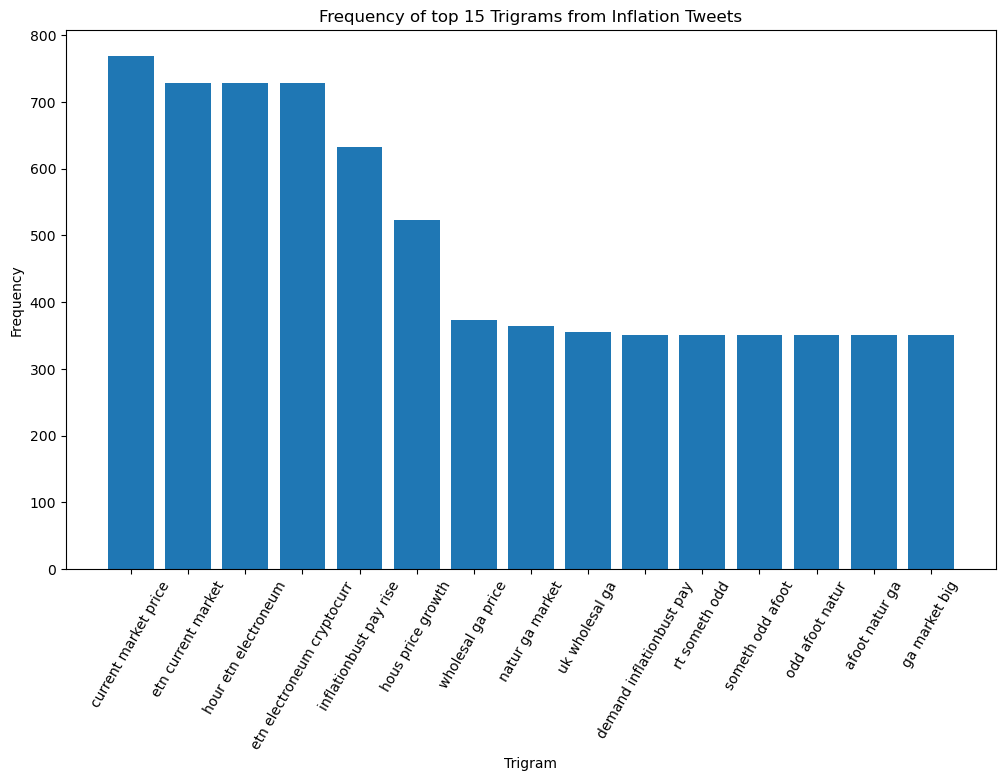

In [ ]:
trigram = trigram.iloc[:15]
plt.figure(figsize=(12,7))
plt.bar(x = trigram['trigram'], height = trigram['count'])
plt.title('Frequency of top 15 Trigrams from Inflation Tweets')
plt.ylabel('Frequency')
plt.xlabel('Trigram')
plt.xticks(rotation=60);

In [ ]:
common_words = get_top_n_trigram(data_cleaned_inflation_prof['processed_tweet'], 16)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [ ]:
temp = trigram.drop(index=trigram[trigram['trigram'] == 'worri save pace'].index).reset_index(drop=True)
inflationProfessionalTweetsTop15Trigrams = temp.iloc[:15].trigram.to_list()

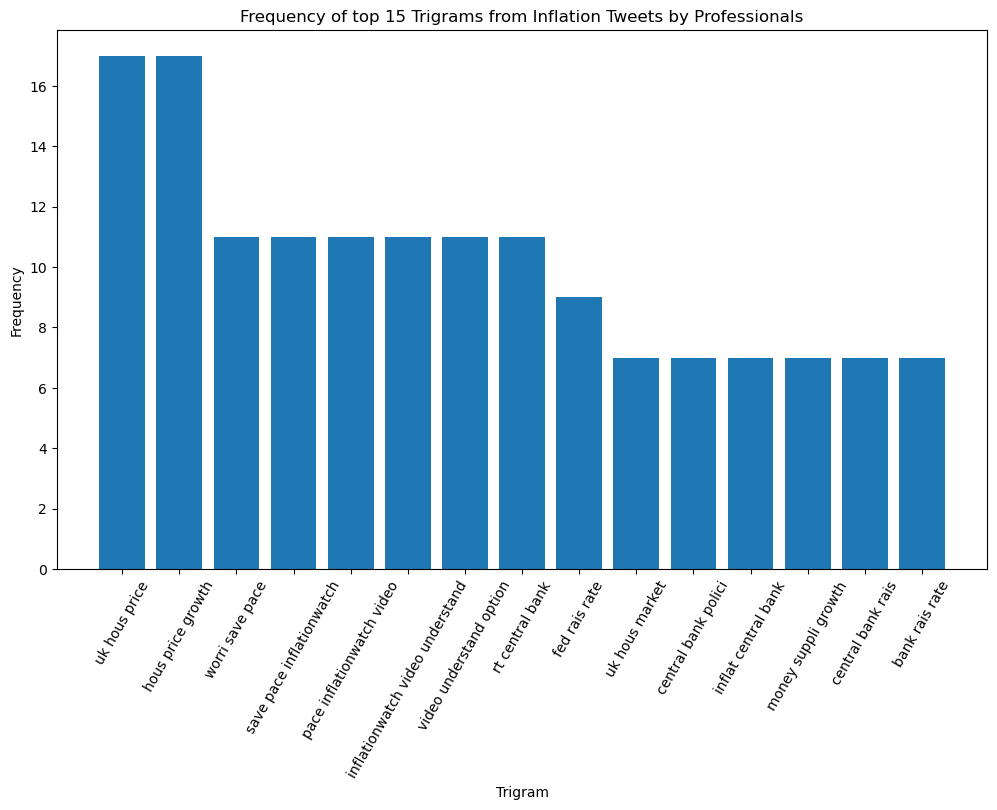

In [ ]:
trigram = trigram.iloc[:15]
plt.figure(figsize=(12,7))
plt.bar(x = trigram['trigram'], height = trigram['count'])
plt.title('Frequency of top 15 Trigrams from Inflation Tweets by Professionals')
plt.ylabel('Frequency')
plt.xlabel('Trigram')
plt.xticks(rotation=60);

### 3. Feature Engineering for the grams

In [ ]:
top15grams = [
allTweetsTop15Unigrams, allTweetsTop15Bigrams, allTweetsTop15Trigrams,
inflationTweetsTop15Unigrams, inflationTweetsTop15Bigrams, inflationTweetsTop15Trigrams,
inflationProfessionalTweetsTop15Unigrams, inflationProfessionalTweetsTop15Bigrams, inflationProfessionalTweetsTop15Trigrams
]

top15grams_cols = [
'allTweetsTop15Unigrams', 'allTweetsTop15Bigrams', 'allTweetsTop15Trigrams',
'inflationTweetsTop15Unigrams', 'inflationTweetsTop15Bigrams', 'inflationTweetsTop15Trigrams',
'inflationProfessionalTweetsTop15Unigrams', 'inflationProfessionalTweetsTop15Bigrams', 'inflationProfessionalTweetsTop15Trigrams'
]

In [ ]:
for i in range(len(top15grams)):
    for gram in tqdm(top15grams[i]):
        data_cleaned[top15grams_cols[i]] = data_cleaned.processed_tweet.str.contains(gram)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

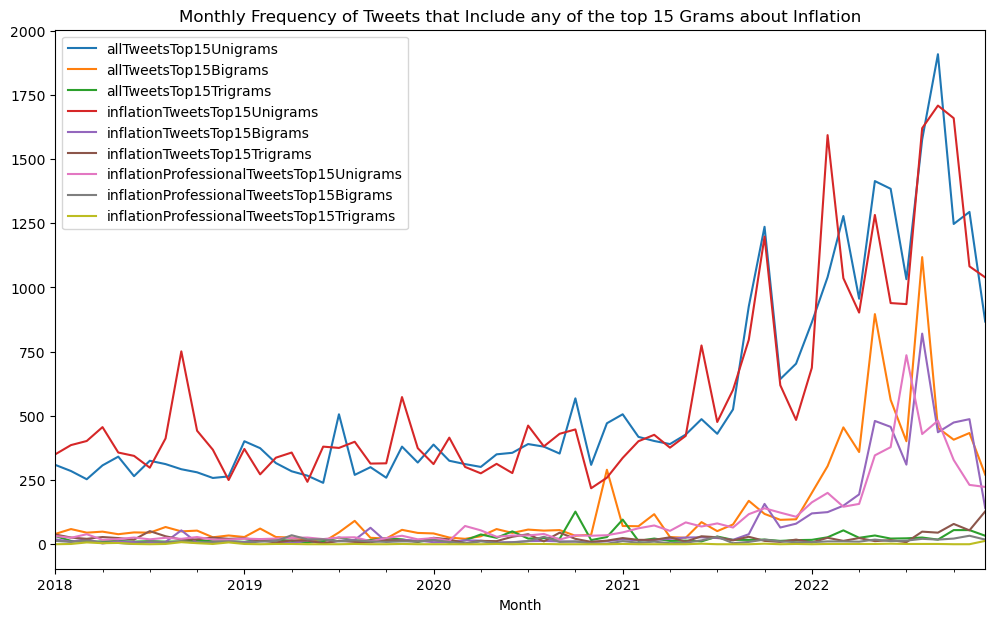

In [ ]:
data_cleaned.groupby('Month').sum().iloc[:,-9:].plot(figsize=(12,7))
plt.title('Monthly Frequency of Tweets that Include any of the top 15 Grams about Inflation');

In [ ]:
temp = data_cleaned.groupby('Month').sum().iloc[:,-9:].reset_index()
temp = temp.rename(columns={'Month': 'Month'})
temp['Month'] = pd.to_datetime(temp['Month'])
temp = temp.set_index('Month')
temp = temp.rename(columns={col: 'sumOf'+col for col in temp.columns})

In [ ]:
indicators_df = pd.concat([indicators_df, temp], axis=1)

In [ ]:
temp = data_cleaned.groupby('Month').mean().iloc[:,-9:].reset_index()
temp = temp.rename(columns={'Month': 'Month'})
temp['Month'] = pd.to_datetime(temp['Month'])
temp = temp.set_index('Month')
temp = temp.rename(columns={col: 'meanOf'+col for col in temp.columns})

In [ ]:
indicators_df = pd.concat([indicators_df, temp], axis=1)

In [ ]:
data_cleaned.to_csv('tweets_cleaned_original.csv')

In [ ]:
indicators_df.to_csv('inflation_indicators.csv')

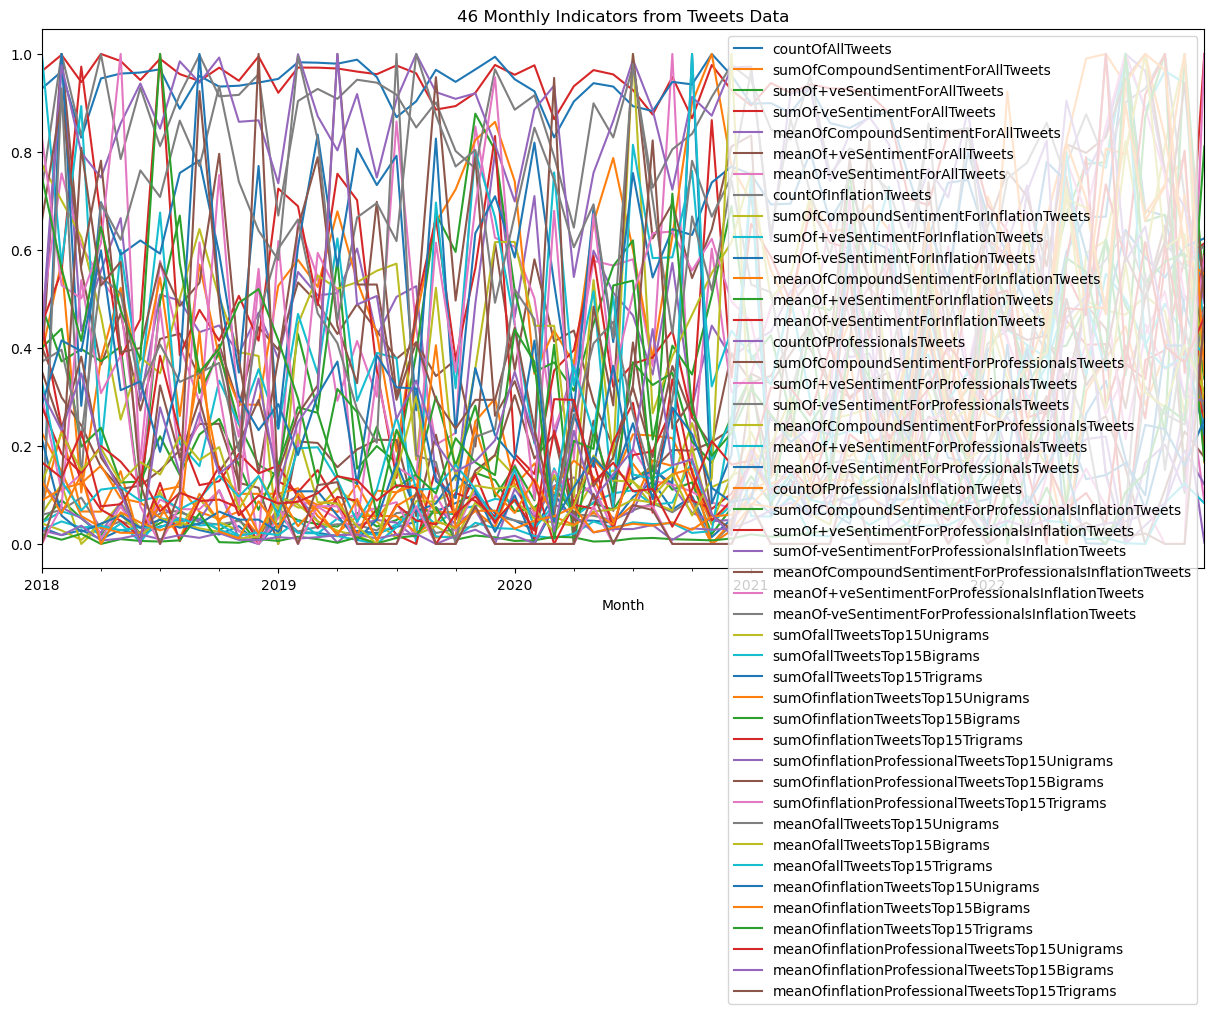

In [ ]:
((indicators_df-indicators_df.min())/(indicators_df.max()-indicators_df.min())).plot(figsize=(15, 7))
plt.title('46 Monthly Indicators from Tweets Data');

## Extracting Embeddings of Tweets using Bert

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-distilroberta-v1')

In [ ]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']


#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

In [ ]:
embedding.shape

(1, 768)

In [ ]:
df_body_month = ['. '.join(group['body']) for date, group in data_cleaned.groupby('Month')]
df_inflation_body_month = ['. '.join(group['body']) for date, group in data_cleaned_inflation.groupby('Month')]
df_professionals_body_month = ['. '.join(group['body']) for date, group in data_cleaned_prof.groupby('Month')]
df_professionals_inflation_body_month = ['. '.join(group['body']) for date, group in data_cleaned_inflation_prof.groupby('Month')]

In [ ]:
month_agg_bert = model.encode(df_body_month, batch_size = 250, show_progress_bar = True)
month_agg_bert_inflation = model.encode(df_inflation_body_month, batch_size = 250, show_progress_bar = True)
month_agg_bert_professionals = model.encode(df_professionals_body_month, batch_size = 250, show_progress_bar = True)
month_agg_bert_professionals_inflation = model.encode(df_professionals_inflation_body_month, batch_size = 250, show_progress_bar = True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
month_agg_bert.shape

(60, 768)

In [ ]:
month_agg_bert_inflation.shape

(60, 768)

In [ ]:
with open('./month_agg_bert.pkl', 'wb') as f:
    pickle.dump(month_agg_bert, f)

with open('./month_agg_bert_inflation.pkl', 'wb') as f:
    pickle.dump(month_agg_bert_inflation, f)

with open('./month_agg_bert_professionals.pkl', 'wb') as f:
    pickle.dump(month_agg_bert_professionals, f)

with open('./month_agg_bert_professionals_inflation.pkl', 'wb') as f:
    pickle.dump(month_agg_bert_professionals_inflation, f)

## Inflation Data

''

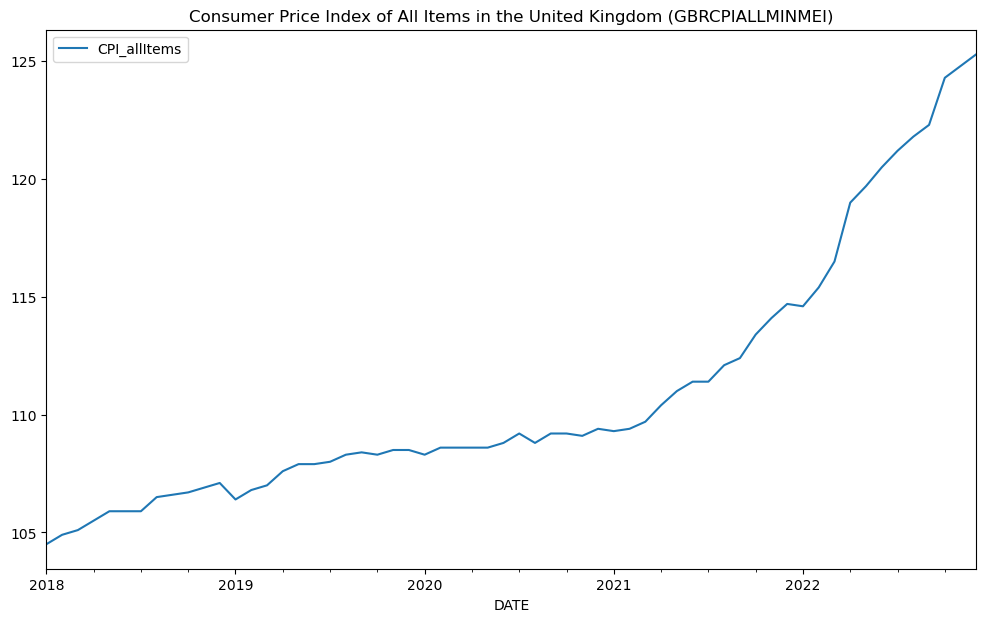

In [ ]:
CPI_allItems = pd.read_csv('GBRCPIALLMINMEI.csv')
CPI_allItems = CPI_allItems.rename(columns={'GBRCPIALLMINMEI': 'CPI_allItems'})
CPI_allItems['DATE'] = pd.to_datetime(CPI_allItems['DATE'])
CPI_allItems = CPI_allItems.set_index('DATE')
CPI_allItems = CPI_allItems['2018-01-01': '2022-12-31']
CPI_allItems.plot(figsize=(12,7))
plt.title('Consumer Price Index of All Items in the United Kingdom (GBRCPIALLMINMEI)')
;

In [ ]:
CPI_allItems

CPI_allItems
DATE                    
2018-01-01         104.5
2018-02-01         104.9
2018-03-01         105.1
2018-04-01         105.5
2018-05-01         105.9
2018-06-01         105.9
2018-07-01         105.9
2018-08-01         106.5
2018-09-01         106.6
2018-10-01         106.7
2018-11-01         106.9
2018-12-01         107.1
2019-01-01         106.4
2019-02-01         106.8
2019-03-01         107.0
2019-04-01         107.6
2019-05-01         107.9
2019-06-01         107.9
2019-07-01         108.0
2019-08-01         108.3
2019-09-01         108.4
2019-10-01         108.3
2019-11-01         108.5
2019-12-01         108.5
2020-01-01         108.3
2020-02-01         108.6
2020-03-01         108.6
2020-04-01         108.6
2020-05-01         108.6
2020-06-01         108.8
2020-07-01         109.2
2020-08-01         108.8
2020-09-01         109.2
2020-10-01         109.2
2020-11-01         109.1
2020-12-01         109.4
2021-01-01         109.3
2021-02-01         109.4
2021-03-01         109.7
2021-04-01         110.4
2021-05-01         111.0
2021-06-01         111.4
2021-07-01         111.4
2021-08-01         112.1
2021-09-01         112.4
2021-10-01         113.4
2021-11-01         114.1
2021-12-01         114.7
2022-01-01         114.6
2022-02-01         115.4
2022-03-01         116.5
2022-04-01         119.0
2022-05-01         119.7
2022-06-01         120.5
2022-07-01         121.2
2022-08-01         121.8
2022-09-01         122.3
2022-10-01         124.3
2022-11-01         124.8
2022-12-01         125.3

''

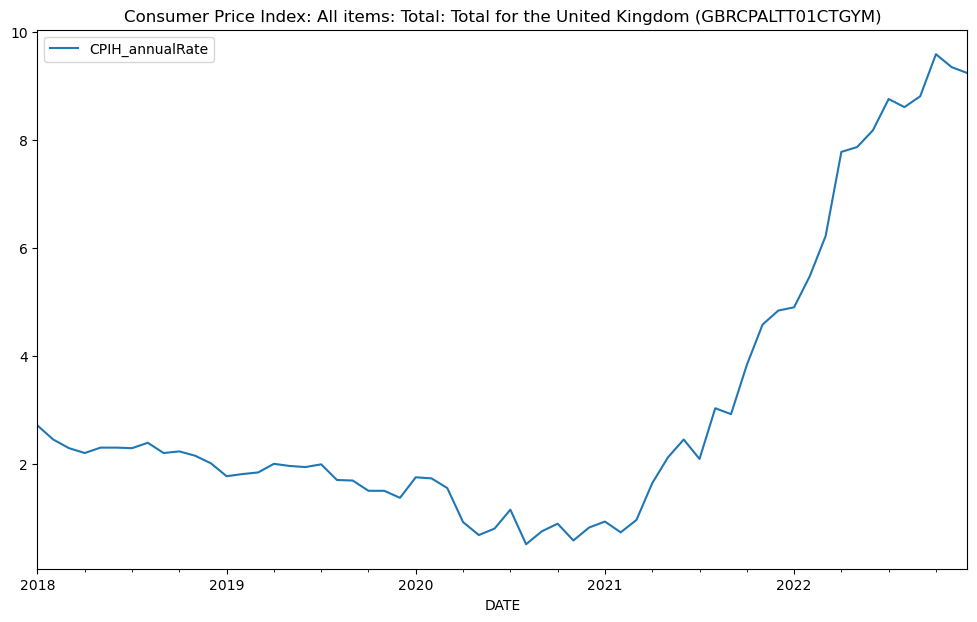

In [ ]:
CPIH_annualRate = pd.read_csv('GBRCPALTT01CTGYM.csv')
CPIH_annualRate = CPIH_annualRate.rename(columns={'GBRCPALTT01CTGYM': 'CPIH_annualRate'})
CPIH_annualRate['DATE'] = pd.to_datetime(CPIH_annualRate['DATE'])
CPIH_annualRate = CPIH_annualRate.set_index('DATE')
CPIH_annualRate = CPIH_annualRate['2018-01-01': '2022-12-31']
CPIH_annualRate.plot(figsize=(12,7))
plt.title('Consumer Price Index: All items: Total: Total for the United Kingdom (GBRCPALTT01CTGYM)')
;

In [ ]:
CPIH_annualRate

CPIH_annualRate
DATE                       
2018-01-01             2.71
2018-02-01             2.45
2018-03-01             2.29
2018-04-01             2.20
2018-05-01             2.30
2018-06-01             2.30
2018-07-01             2.29
2018-08-01             2.39
2018-09-01             2.20
2018-10-01             2.23
2018-11-01             2.15
2018-12-01             2.01
2019-01-01             1.77
2019-02-01             1.81
2019-03-01             1.84
2019-04-01             2.00
2019-05-01             1.96
2019-06-01             1.94
2019-07-01             1.99
2019-08-01             1.70
2019-09-01             1.69
2019-10-01             1.50
2019-11-01             1.50
2019-12-01             1.37
2020-01-01             1.75
2020-02-01             1.73
2020-03-01             1.55
2020-04-01             0.92
2020-05-01             0.68
2020-06-01             0.80
2020-07-01             1.15
2020-08-01             0.51
2020-09-01             0.75
2020-10-01             0.89
2020-11-01             0.58
2020-12-01             0.82
2021-01-01             0.93
2021-02-01             0.73
2021-03-01             0.96
2021-04-01             1.64
2021-05-01             2.12
2021-06-01             2.45
2021-07-01             2.09
2021-08-01             3.03
2021-09-01             2.92
2021-10-01             3.83
2021-11-01             4.58
2021-12-01             4.84
2022-01-01             4.90
2022-02-01             5.48
2022-03-01             6.22
2022-04-01             7.78
2022-05-01             7.87
2022-06-01             8.18
2022-07-01             8.76
2022-08-01             8.61
2022-09-01             8.81
2022-10-01             9.59
2022-11-01             9.35
2022-12-01             9.24

''

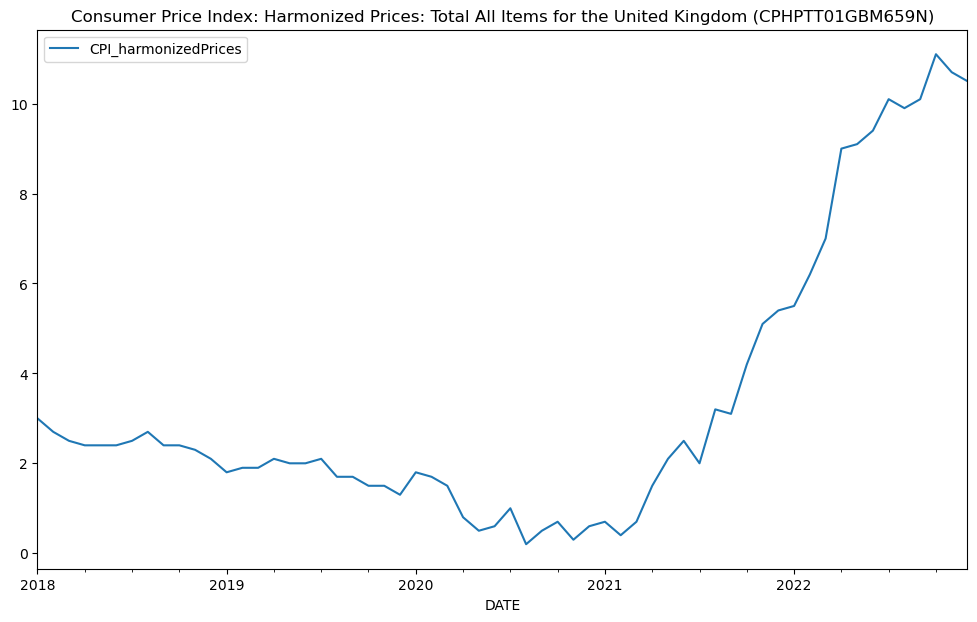

In [ ]:
CPI_harmonizedPrices = pd.read_csv('CPHPTT01GBM659N.csv')
CPI_harmonizedPrices = CPI_harmonizedPrices.rename(columns={'CPHPTT01GBM659N': 'CPI_harmonizedPrices'})
CPI_harmonizedPrices['DATE'] = pd.to_datetime(CPI_harmonizedPrices['DATE'])
CPI_harmonizedPrices = CPI_harmonizedPrices.set_index('DATE')
CPI_harmonizedPrices = CPI_harmonizedPrices['2018-01-01': '2022-12-31']
CPI_harmonizedPrices.plot(figsize=(12,7))
plt.title('Consumer Price Index: Harmonized Prices: Total All Items for the United Kingdom (CPHPTT01GBM659N)')
;

In [ ]:
CPI_harmonizedPrices

CPI_harmonizedPrices
DATE                            
2018-01-01                   3.0
2018-02-01                   2.7
2018-03-01                   2.5
2018-04-01                   2.4
2018-05-01                   2.4
2018-06-01                   2.4
2018-07-01                   2.5
2018-08-01                   2.7
2018-09-01                   2.4
2018-10-01                   2.4
2018-11-01                   2.3
2018-12-01                   2.1
2019-01-01                   1.8
2019-02-01                   1.9
2019-03-01                   1.9
2019-04-01                   2.1
2019-05-01                   2.0
2019-06-01                   2.0
2019-07-01                   2.1
2019-08-01                   1.7
2019-09-01                   1.7
2019-10-01                   1.5
2019-11-01                   1.5
2019-12-01                   1.3
2020-01-01                   1.8
2020-02-01                   1.7
2020-03-01                   1.5
2020-04-01                   0.8
2020-05-01                   0.5
2020-06-01                   0.6
2020-07-01                   1.0
2020-08-01                   0.2
2020-09-01                   0.5
2020-10-01                   0.7
2020-11-01                   0.3
2020-12-01                   0.6
2021-01-01                   0.7
2021-02-01                   0.4
2021-03-01                   0.7
2021-04-01                   1.5
2021-05-01                   2.1
2021-06-01                   2.5
2021-07-01                   2.0
2021-08-01                   3.2
2021-09-01                   3.1
2021-10-01                   4.2
2021-11-01                   5.1
2021-12-01                   5.4
2022-01-01                   5.5
2022-02-01                   6.2
2022-03-01                   7.0
2022-04-01                   9.0
2022-05-01                   9.1
2022-06-01                   9.4
2022-07-01                  10.1
2022-08-01                   9.9
2022-09-01                  10.1
2022-10-01                  11.1
2022-11-01                  10.7
2022-12-01                  10.5

''

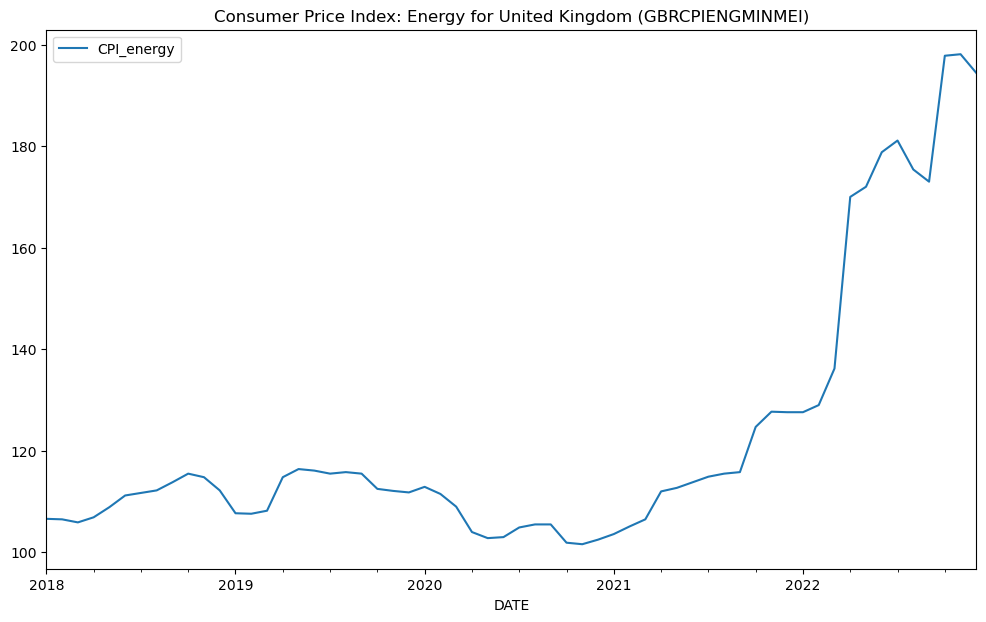

In [ ]:
CPI_energy = pd.read_csv('GBRCPIENGMINMEI.csv')
CPI_energy = CPI_energy.rename(columns={'GBRCPIENGMINMEI': 'CPI_energy'})
CPI_energy['DATE'] = pd.to_datetime(CPI_energy['DATE'])
CPI_energy = CPI_energy.set_index('DATE')
CPI_energy = CPI_energy['2018-01-01': '2022-12-31']
CPI_energy.plot(figsize=(12,7))
plt.title('Consumer Price Index: Energy for United Kingdom (GBRCPIENGMINMEI)')
;

'CPI_allItems'

In [ ]:
for i in [CPI_allItems, CPIH_annualRate, CPI_energy]:
    display(pd.concat([indicators_df, i], axis=1).corr()[i.columns[0]])
    print('*'*100)

countOfAllTweets                                          0.895258
sumOfCompoundSentimentForAllTweets                        0.858199
sumOf+veSentimentForAllTweets                             0.891288
sumOf-veSentimentForAllTweets                            -0.874366
meanOfCompoundSentimentForAllTweets                      -0.681778
meanOf+veSentimentForAllTweets                           -0.624231
meanOf-veSentimentForAllTweets                           -0.309846
countOfInflationTweets                                    0.927208
sumOfCompoundSentimentForInflationTweets                  0.806633
sumOf+veSentimentForInflationTweets                       0.924151
sumOf-veSentimentForInflationTweets                      -0.902778
meanOfCompoundSentimentForInflationTweets                -0.283025
meanOf+veSentimentForInflationTweets                      0.080258
meanOf-veSentimentForInflationTweets                     -0.185144
countOfProfessionalsTweets                                0.90

****************************************************************************************************


countOfAllTweets                                          0.893800
sumOfCompoundSentimentForAllTweets                        0.855161
sumOf+veSentimentForAllTweets                             0.890000
sumOf-veSentimentForAllTweets                            -0.874672
meanOfCompoundSentimentForAllTweets                      -0.621749
meanOf+veSentimentForAllTweets                           -0.487280
meanOf-veSentimentForAllTweets                           -0.331327
countOfInflationTweets                                    0.934124
sumOfCompoundSentimentForInflationTweets                  0.739366
sumOf+veSentimentForInflationTweets                       0.896403
sumOf-veSentimentForInflationTweets                      -0.921260
meanOfCompoundSentimentForInflationTweets                -0.484374
meanOf+veSentimentForInflationTweets                     -0.009522
meanOf-veSentimentForInflationTweets                     -0.141995
countOfProfessionalsTweets                                0.88

****************************************************************************************************


countOfAllTweets                                          0.862237
sumOfCompoundSentimentForAllTweets                        0.832381
sumOf+veSentimentForAllTweets                             0.860334
sumOf-veSentimentForAllTweets                            -0.840518
meanOfCompoundSentimentForAllTweets                      -0.598448
meanOf+veSentimentForAllTweets                           -0.478269
meanOf-veSentimentForAllTweets                           -0.322546
countOfInflationTweets                                    0.921756
sumOfCompoundSentimentForInflationTweets                  0.756066
sumOf+veSentimentForInflationTweets                       0.891156
sumOf-veSentimentForInflationTweets                      -0.893598
meanOfCompoundSentimentForInflationTweets                -0.407209
meanOf+veSentimentForInflationTweets                      0.062480
meanOf-veSentimentForInflationTweets                     -0.127596
countOfProfessionalsTweets                                0.83

****************************************************************************************************


# Forecasting

## Data Pre-processing
* From 2018 to 2021 for training (48 months).
* 2022 for testing (12 months).

In [ ]:
inflation_train = CPIH_annualRate[:'2021-12-01']
inflation_test = CPIH_annualRate['2022-01-01':]
inflation_train.shape, inflation_test.shape

((48, 1), (12, 1))

In [ ]:
indicators_train = indicators_df[:'2021-12-01']
indicators_test = indicators_df['2022-01-01':]
indicators_train.shape, indicators_test.shape

((48, 46), (12, 46))

## 1. ARIMA: Baseline

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

result = adfuller(CPIH_annualRate['CPIH_annualRate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -4.625624
p-value: 0.000116


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import statsmodels.api as sm

### Investigating Trend, Seasonality, and Noise

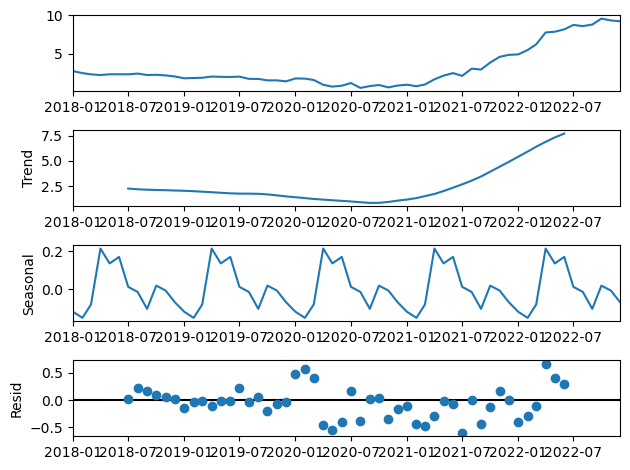

In [ ]:
decomposition = seasonal_decompose(CPIH_annualRate, model='additive')
fig = decomposition.plot()
plt.show()

### ARIMA
ARIMA stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

Also, these three parameters account for seasonality, trend, and noise in data:

In [ ]:
# Create p, d, q combinations.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### Grid Search for Optimal Parameters

In [ ]:
pdq_x_seasonal_pdq = []
aic_ = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(inflation_train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        pdq_x_seasonal_pdq.append('ARIMA{}x{}12'.format(param, param_seasonal))
        aic_.append(results.aic)

C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihoo

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:204.50976379309475
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1409.4496884975517
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:126.51928992417376
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:87.31859037068914
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:129.78278058473455


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provid

ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1653.4502309754685
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:91.73401170532784
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:86.37957603888844
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:151.53637401761267
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1446.8427036816447
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:98.64993163134797
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:68.74266721035747
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:103.42515175347589


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency in

ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1443.0215346760033
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:74.47030961807272
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:66.46218576493284
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:31.76059478424028
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1417.753293088088
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:55.08605819888462


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency in

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:38.6323561251205
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:26.55223638113195
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1432.18062946169
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:38.44494150070333
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:36.638457890058575
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:33.464581210394314


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency in

ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1376.8388238065734
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:56.38061385688948
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:39.90840332460787
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:27.912646573735277
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1606.4968949196268
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:40.39973650998163
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:37.42531888625585
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:32.575330359161555
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1527.947337791632
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:57.434902984261804
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:40.57650521009774
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:27.557834498175676


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provid

ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1523.9723432379396
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:39.9566628340534
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:39.22768188899077
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:33.78641279375394
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1393.1900960202647


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency in

ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:58.31815969337335
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:42.11001608314108
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:29.17903041294758
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1389.3843306328656


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency in

ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:41.95285195032536
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:39.919311345338045
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:33.08117076425867
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1346.5282265824144
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:57.07598972161245
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:40.48024032907412


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency in

ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:27.756117678109284
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1583.0849794830704
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:39.566263624835244
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:37.45277065672283
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:31.579604298115694


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provid

ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1144.3942437214494
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:57.940916183397576
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:38.093110974475614
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:26.197315695141604
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1374.0520592532214
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:40.775563343371005
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:33.246439742522355


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provid

In [ ]:
min(aic_)

26.197315695141604

In [ ]:
least_aic_position = aic_.index(min(aic_))

In [ ]:
pdq_x_seasonal_pdq[least_aic_position]

'ARIMA(1, 1, 1)x(1, 0, 0, 12)12'

### Fitting the Optimal ARIMA model

In [ ]:
mod = sm.tsa.statespace.SARIMAX(inflation_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9922      0.172      5.758      0.000       0.654       1.330
ma.L1         -0.7738      0.231     -3.355      0.001      -1.226      -0.322
ar.S.L12      -0.7311      0.243     -3.004      0.003      -1.208      -0.254
sigma2         0.0973      0.029      3.340      0.001       0.040       0.154


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
mod = sm.tsa.statespace.SARIMAX(inflation_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9922      0.172      5.758      0.000       0.654       1.330
ma.L1         -0.7738      0.231     -3.355      0.001      -1.226      -0.322
ar.S.L12      -0.7311      0.243     -3.004      0.003      -1.208      -0.254
sigma2         0.0973      0.029      3.340      0.001       0.040       0.154


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Plot Model Diagnostics

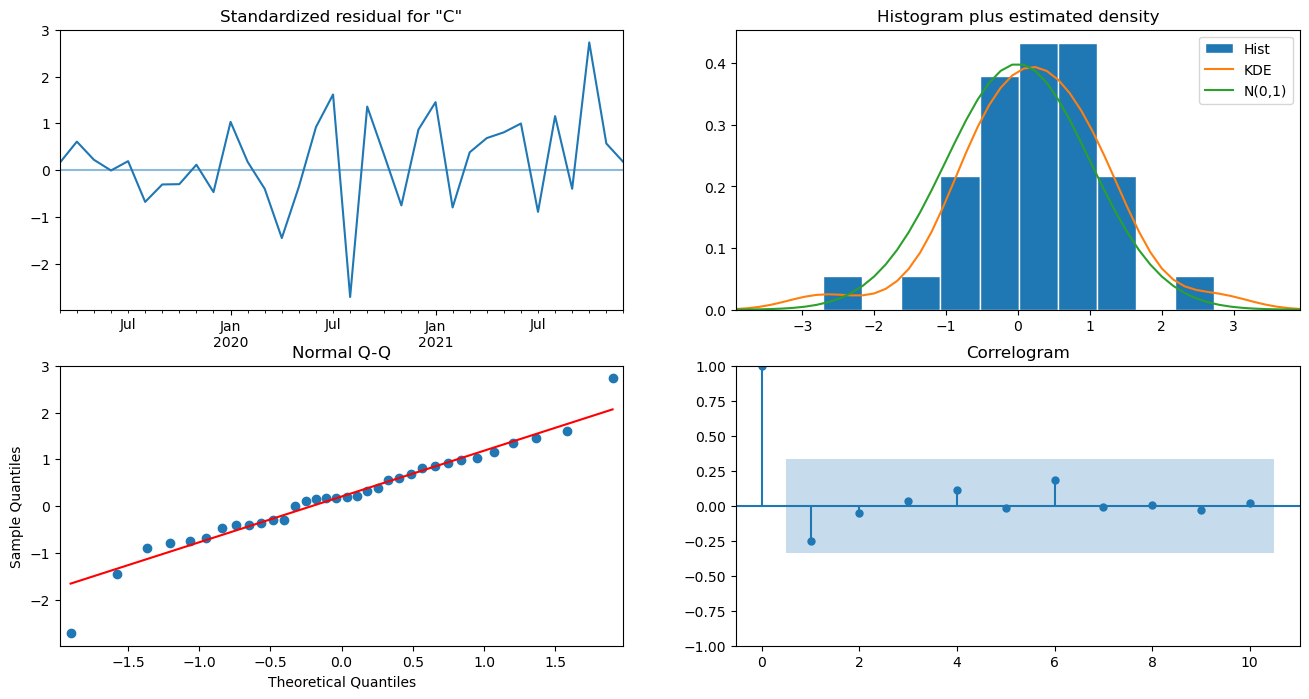

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The model residuals are near normally distributed.

### Validating Forecasts

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'),
                              end=pd.to_datetime('2022-12-01'))
pred_ci = pred.conf_int()

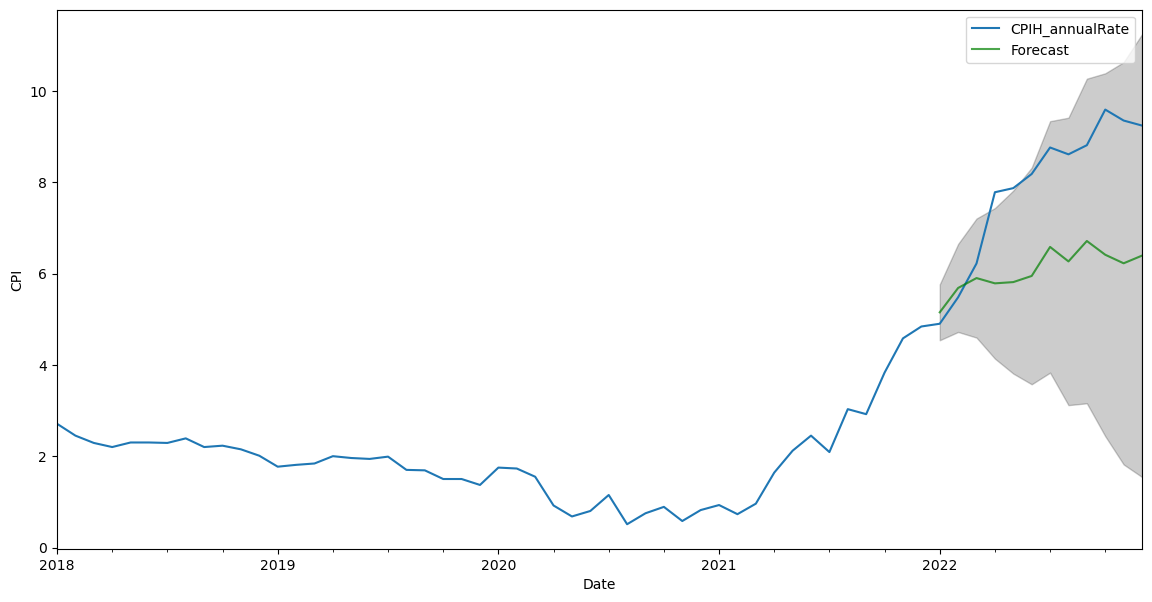

In [ ]:
ax = CPIH_annualRate.plot(label='Ground Truth')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7), color='green')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CPI')
plt.legend()
plt.show()

In [ ]:
monthly_data_forecasted = pred.predicted_mean
monthly_data_truth = inflation_test.CPIH_annualRate
mse = ((monthly_data_forecasted - monthly_data_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4.67


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2.16


## RNN

### 1. Using the indicators extracted from the tweets

In [70]:
import pandas as pd
inflation_indexes = pd.read_csv('/content/inflationIndexes.csv').set_index('DATE')
indicators_df = pd.read_csv('/content/inflation_indicators.csv').set_index('Month')

In [71]:
df_DL = pd.concat([indicators_df, inflation_indexes], axis=1)

In [72]:
target = ['CPI_allItems', 'CPIH_annualRate', 'CPI_energy']

In [73]:
# shift_days = 1
shift_steps = 1 #shift_days * 24  # Number of hours.

In [74]:
df_targets = df_DL[target].shift(-shift_steps)

In [75]:
df_DL[target].head(shift_steps + 5)

CPI_allItems  CPIH_annualRate  CPI_energy
2018-01-01         104.5             2.71       106.6
2018-02-01         104.9             2.45       106.5
2018-03-01         105.1             2.29       105.9
2018-04-01         105.5             2.20       106.9
2018-05-01         105.9             2.30       108.9
2018-06-01         105.9             2.30       111.2

In [76]:
df_DL[target].head()

CPI_allItems  CPIH_annualRate  CPI_energy
2018-01-01         104.5             2.71       106.6
2018-02-01         104.9             2.45       106.5
2018-03-01         105.1             2.29       105.9
2018-04-01         105.5             2.20       106.9
2018-05-01         105.9             2.30       108.9

In [77]:
df_targets.tail()

CPI_allItems  CPIH_annualRate  CPI_energy
2022-08-01         122.3             8.81       173.0
2022-09-01         124.3             9.59       197.8
2022-10-01         124.8             9.35       198.1
2022-11-01         125.3             9.24       194.4
2022-12-01           NaN              NaN         NaN

In [78]:
# Rhe input-samples
x_data = df_DL.values[0:-shift_steps]

In [79]:
# The target-samples
y_data = df_targets.values[:-shift_steps]

In [80]:
# The number of samples in the data-set:
num_data = len(x_data)
num_data

59

In [81]:
# TThe fraction of the data-set that will be used for the training-set
train_split = 0.8

In [82]:
# The number of samples in the training-set:
num_train = int(train_split * num_data)
num_train

47

In [83]:
# The number of samples in the test-set:
num_test = num_data - num_train
num_test

12

In [84]:
# the training-samples for the training and test-sets
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

In [85]:
# the testing-samples for the training and test-sets
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [86]:
# Number of features
num_x_signals = x_data.shape[1]
num_x_signals

49

In [87]:
# This is the number of targets
num_y_signals = y_data.shape[1]
num_y_signals

3

In [88]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [89]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [90]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(47, 49)
(47, 3)


In [91]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)

            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]

        yield (x_batch, y_batch)

In [92]:
batch_size = 6

In [93]:
sequence_length = 12
sequence_length

12

In [94]:
# create the batch-generator
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [95]:
import numpy as np
# test the batch-generator to see if it works
x_batch, y_batch = next(generator)

In [96]:
print(x_batch.shape)
print(y_batch.shape)

(6, 12, 49)
(6, 12, 3)


In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [98]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [99]:
model = Sequential()

In [100]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

In [101]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.

    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))

    return mse

In [102]:
warmup_steps = 6

In [103]:
optimizer = RMSprop(lr=1e-3)

In [104]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [105]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 512)         864768    
                                                                 
 dense_2 (Dense)             (None, None, 3)           1539      
                                                                 
Total params: 866,307
Trainable params: 866,307
Non-trainable params: 0
_________________________________________________________________


In [106]:
path_checkpoint = '/content/checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [107]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [108]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [109]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [110]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [111]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0152
Epoch 1: val_loss improved from inf to 2.33993, saving model to /content/checkpoint.keras
100/100 [==============================] - 7s 49ms/step - loss: 0.0152 - val_loss: 2.3399 - lr: 0.0010
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 2: val_loss improved from 2.33993 to 2.33794, saving model to /content/checkpoint.keras
100/100 [==============================] - 4s 42ms/step - loss: 0.0056 - val_loss: 2.3379 - lr: 0.0010
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 3: val_loss improved from 2.33794 to 2.33768, saving model to /content/checkpoint.keras
100/100 [==============================] - 5s 49ms/step - loss: 0.0035 - val_loss: 2.3377 - lr: 0.0010
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 4: val_loss improved from 2.33768 to 2.33753, saving model to /content/checkpoint.keras
100/100 [==

In [112]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 23ms/step - loss: 2.3375


In [115]:
import matplotlib.pyplot as plt

In [116]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.

    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """

    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test

    # End-index for the sequences.
    end_idx = start_idx + length

    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]

    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)

    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    # For each output-signal.
    for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]

        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,7))

        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')

        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()

1/1 [==============================] - 0s 98ms/step


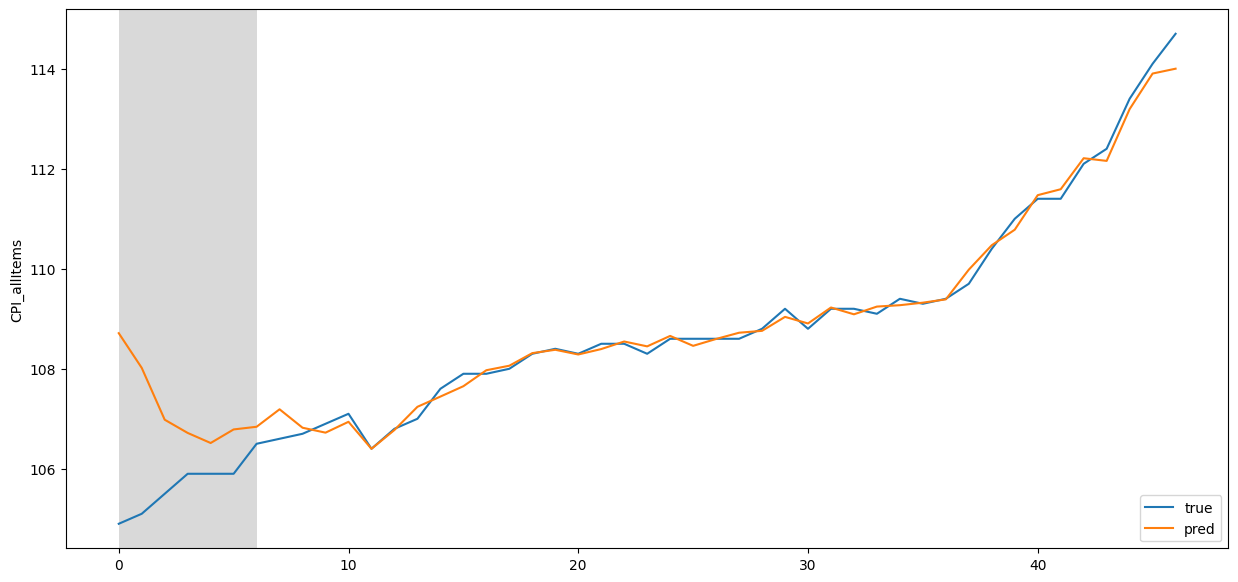

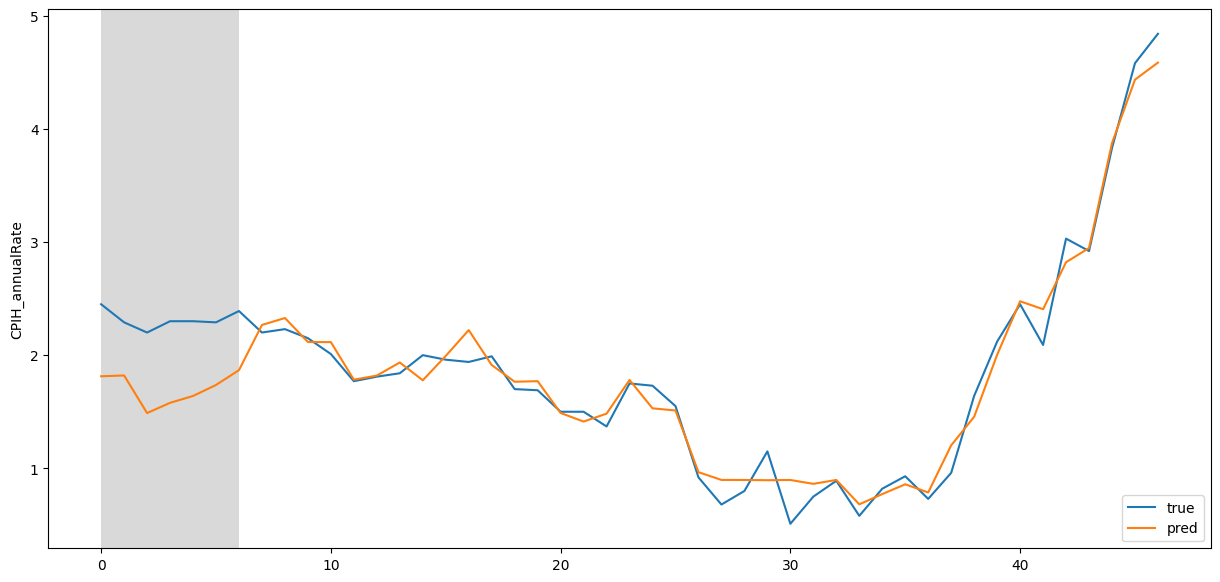

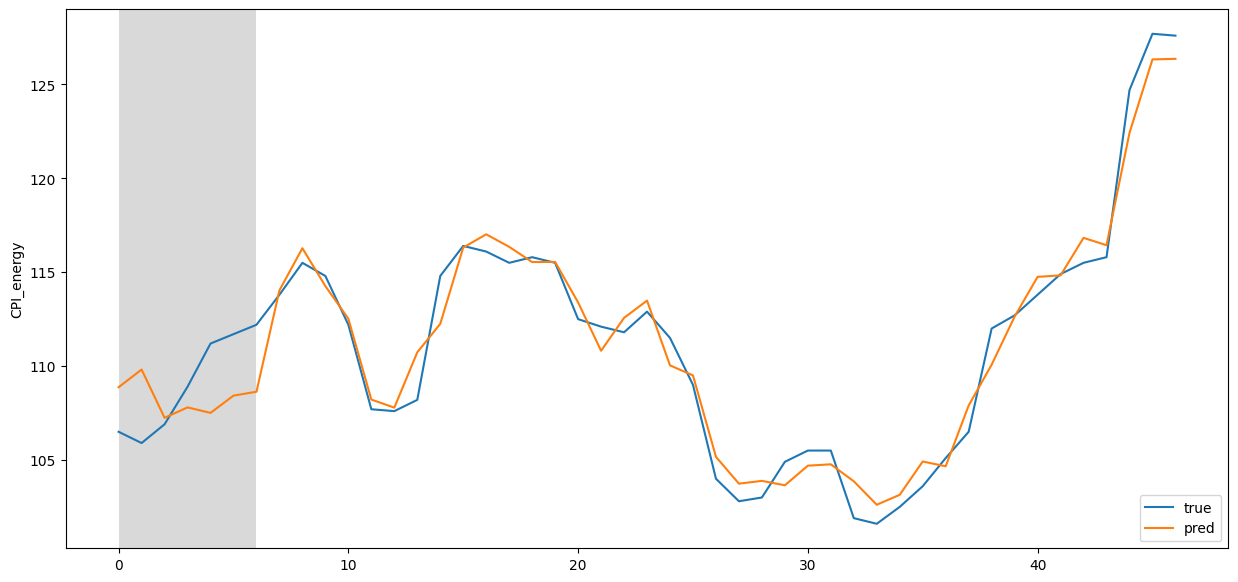

In [117]:
plot_comparison(start_idx=0, length=500, train=True)

1/1 [==============================] - 1s 988ms/step


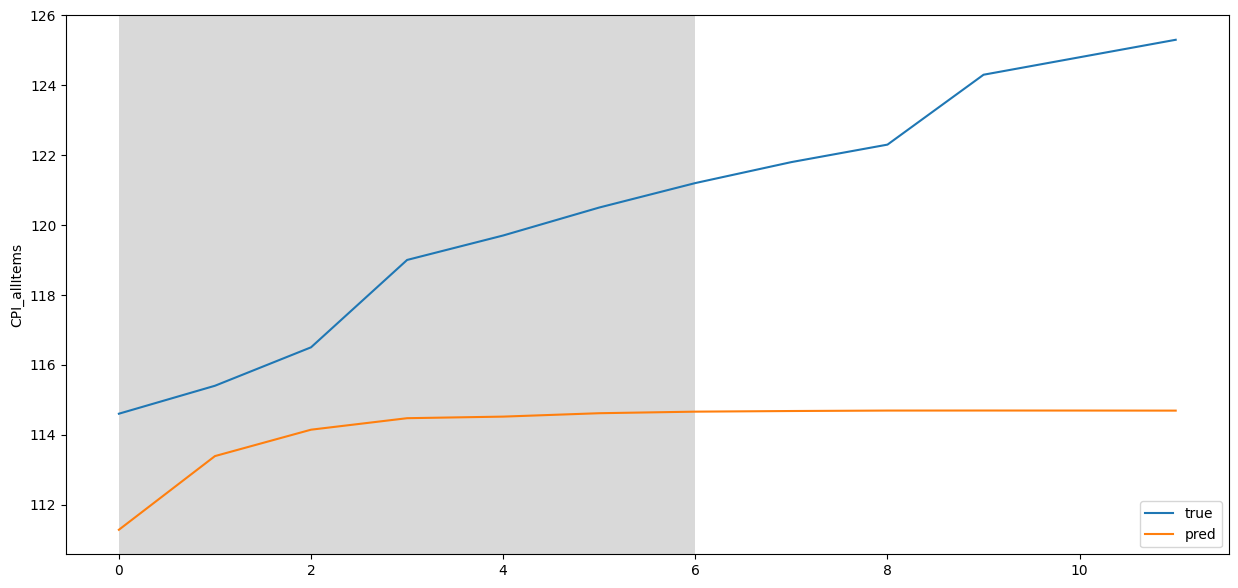

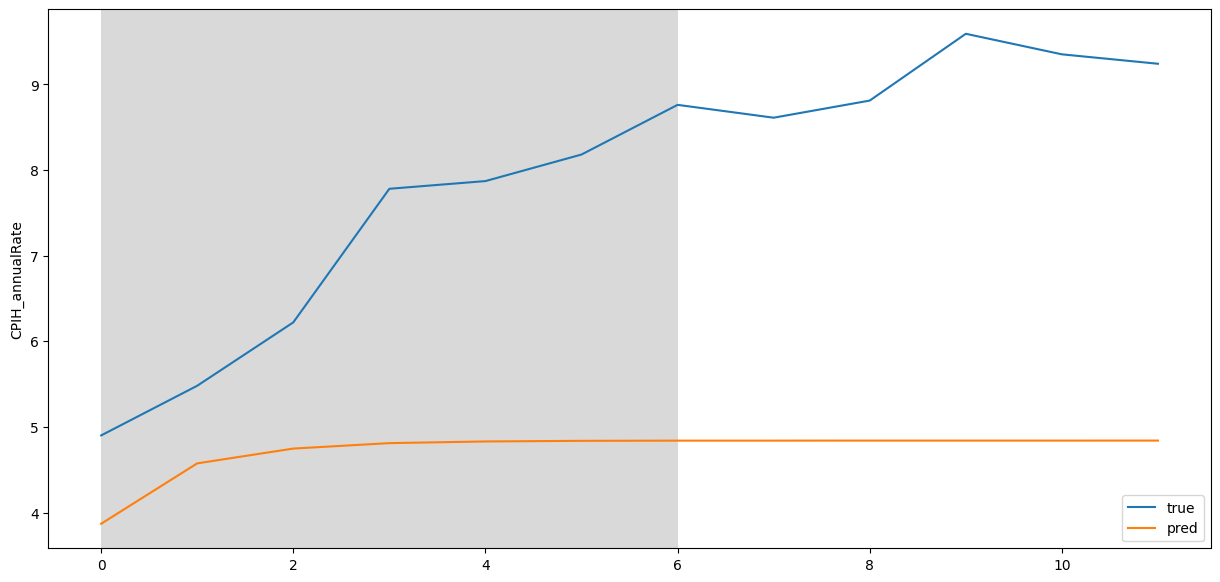

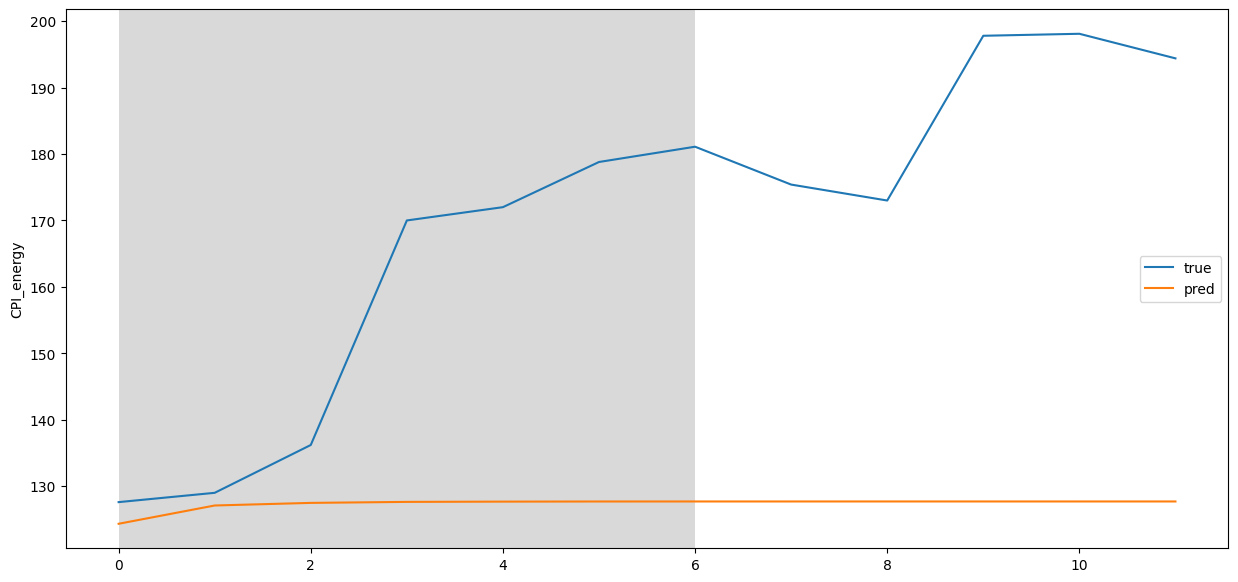

In [118]:
plot_comparison(start_idx=0, length=12, train=False)

### 2. Using the indicators extracted from the tweets and Bert Embeddings.

In [ ]:
import pandas as pd
inflation_indexes = pd.read_csv('/content/inflationIndexes.csv').set_index('DATE')
indicators_df = pd.read_csv('/content/inflation_indicators.csv').set_index('Month')

In [119]:
month_agg_bert_inflation = pd.DataFrame(pd.read_pickle('./month_agg_bert_inflation.pkl'), index=indicators_df.index.to_list())
month_agg_bert_professionals_inflation = pd.DataFrame(pd.read_pickle('./month_agg_bert_professionals_inflation.pkl'), index=indicators_df.index.to_list())
month_agg_bert_professionals = pd.DataFrame(pd.read_pickle('./month_agg_bert_professionals.pkl'), index=indicators_df.index.to_list())
month_agg_bert = pd.DataFrame(pd.read_pickle('./month_agg_bert.pkl'), index=indicators_df.index.to_list())

In [120]:
month_agg_bert_inflation.shape

(60, 768)

In [121]:
df_DL = pd.concat([indicators_df,
                   month_agg_bert_inflation, month_agg_bert_professionals_inflation,
                  month_agg_bert_professionals, month_agg_bert,
                   inflation_indexes], axis=1)

In [122]:
target = ['CPI_allItems', 'CPIH_annualRate', 'CPI_energy']

In [123]:
# shift_days = 1
shift_steps = 1 #shift_days * 24  # Number of hours.

In [124]:
df_targets = df_DL[target].shift(-shift_steps)

In [125]:
df_DL[target].head(shift_steps + 5)

CPI_allItems  CPIH_annualRate  CPI_energy
2018-01-01         104.5             2.71       106.6
2018-02-01         104.9             2.45       106.5
2018-03-01         105.1             2.29       105.9
2018-04-01         105.5             2.20       106.9
2018-05-01         105.9             2.30       108.9
2018-06-01         105.9             2.30       111.2

In [126]:
df_DL[target].head()

CPI_allItems  CPIH_annualRate  CPI_energy
2018-01-01         104.5             2.71       106.6
2018-02-01         104.9             2.45       106.5
2018-03-01         105.1             2.29       105.9
2018-04-01         105.5             2.20       106.9
2018-05-01         105.9             2.30       108.9

In [127]:
df_targets.tail()

CPI_allItems  CPIH_annualRate  CPI_energy
2022-08-01         122.3             8.81       173.0
2022-09-01         124.3             9.59       197.8
2022-10-01         124.8             9.35       198.1
2022-11-01         125.3             9.24       194.4
2022-12-01           NaN              NaN         NaN

In [128]:
# Rhe input-samples
x_data = df_DL.values[0:-shift_steps]

In [129]:
# The target-samples
y_data = df_targets.values[:-shift_steps]

In [130]:
# The number of samples in the data-set:
num_data = len(x_data)
num_data

59

In [131]:
# TThe fraction of the data-set that will be used for the training-set
train_split = 0.8

In [132]:
# The number of samples in the training-set:
num_train = int(train_split * num_data)
num_train

47

In [133]:
# The number of samples in the test-set:
num_test = num_data - num_train
num_test

12

In [134]:
# the training-samples for the training and test-sets
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

In [135]:
# the testing-samples for the training and test-sets
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [136]:
# Number of features
num_x_signals = x_data.shape[1]
num_x_signals

3121

In [137]:
# This is the number of targets
num_y_signals = y_data.shape[1]
num_y_signals

3

In [138]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [139]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [140]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(47, 3121)
(47, 3)


In [141]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)

            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]

        yield (x_batch, y_batch)

In [142]:
batch_size = 6

In [143]:
sequence_length = 12
sequence_length

12

In [144]:
# create the batch-generator
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [145]:
import numpy as np
# test the batch-generator to see if it works
x_batch, y_batch = next(generator)

In [146]:
print(x_batch.shape)
print(y_batch.shape)

(6, 12, 3121)
(6, 12, 3)


In [147]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [148]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [167]:
model = Sequential()

In [168]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

In [169]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.

    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))

    return mse

In [170]:
warmup_steps = 6

In [171]:
optimizer = RMSprop(lr=1e-3)

In [172]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [173]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, None, 512)         5583360   
                                                                 
 dense_4 (Dense)             (None, None, 3)           1539      
                                                                 
Total params: 5,584,899
Trainable params: 5,584,899
Non-trainable params: 0
_________________________________________________________________


In [174]:
path_checkpoint = '/content/checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [175]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [176]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [177]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-10,
                                       patience=0,
                                       verbose=1)

In [178]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [179]:
%%time
model.fit(x=generator,
          epochs=100,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.0836
Epoch 1: val_loss improved from inf to 5.63651, saving model to /content/checkpoint.keras
100/100 [==============================] - 18s 159ms/step - loss: 0.0836 - val_loss: 5.6365 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.0852
Epoch 2: val_loss improved from 5.63651 to 5.62650, saving model to /content/checkpoint.keras
100/100 [==============================] - 14s 144ms/step - loss: 0.0852 - val_loss: 5.6265 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.0792
Epoch 3: val_loss improved from 5.62650 to 5.55840, saving model to /content/checkpoint.keras
100/100 [==============================] - 14s 143ms/step - loss: 0.0792 - val_loss: 5.5584 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.0794
Epoch 4: val_loss did not improve from 5.55840

Epoch 4: ReduceLROnPlateau reducing learning ra

In [180]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 29ms/step - loss: 5.5153


In [181]:
import matplotlib.pyplot as plt

In [182]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.

    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """

    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test

    # End-index for the sequences.
    end_idx = start_idx + length

    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]

    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)

    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    # For each output-signal.
    for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]

        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,7))

        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')

        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()

1/1 [==============================] - 0s 331ms/step


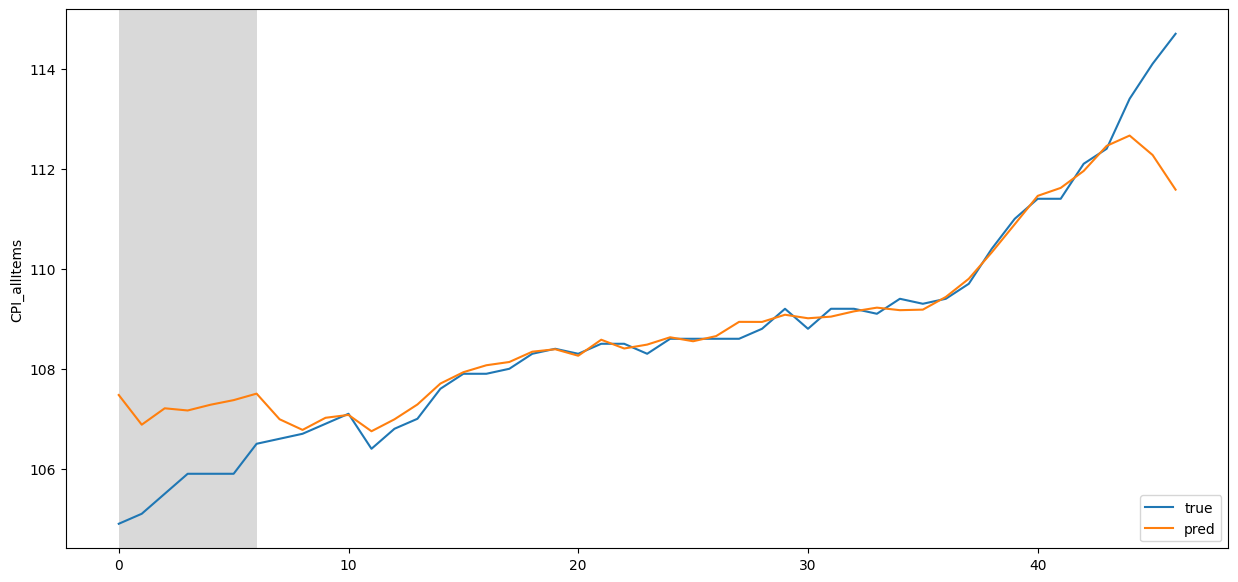

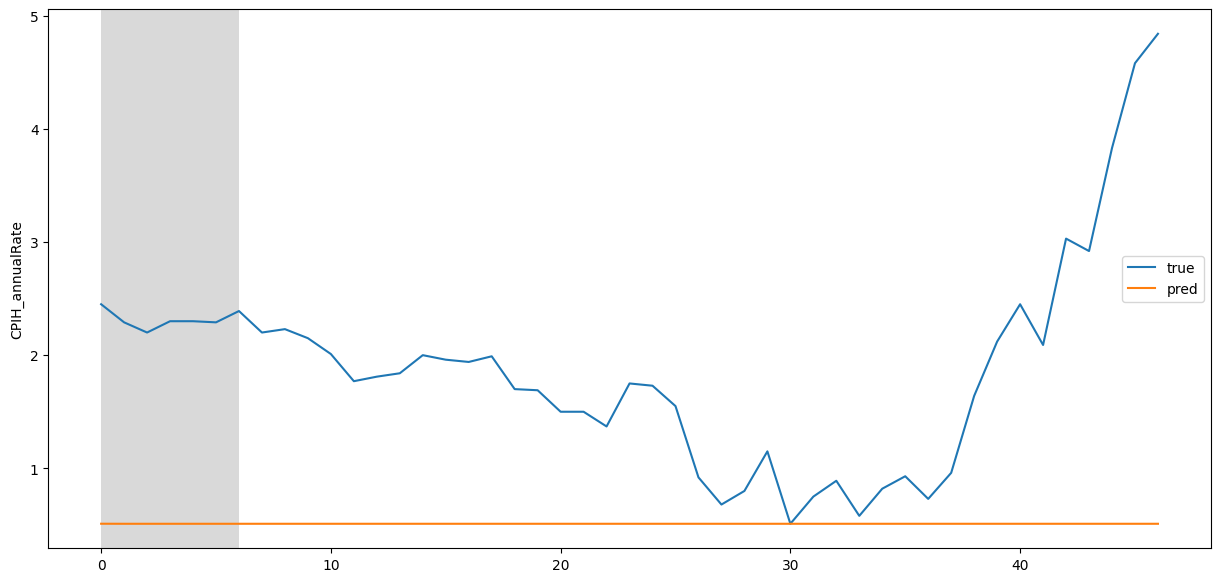

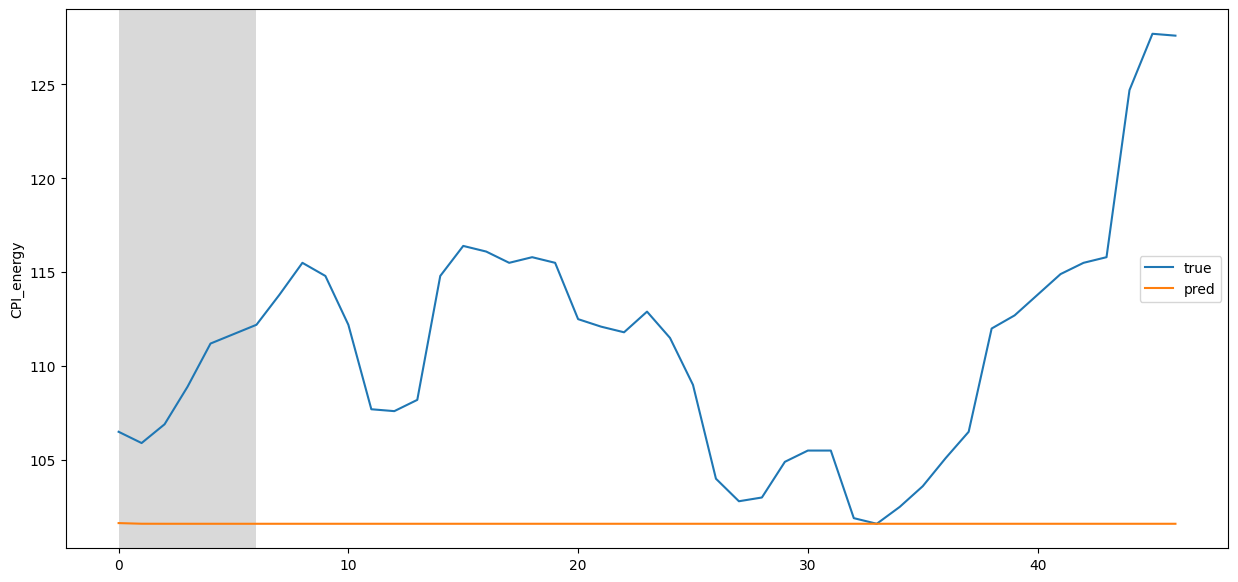

In [183]:
plot_comparison(start_idx=0, length=500, train=True)

1/1 [==============================] - 0s 355ms/step


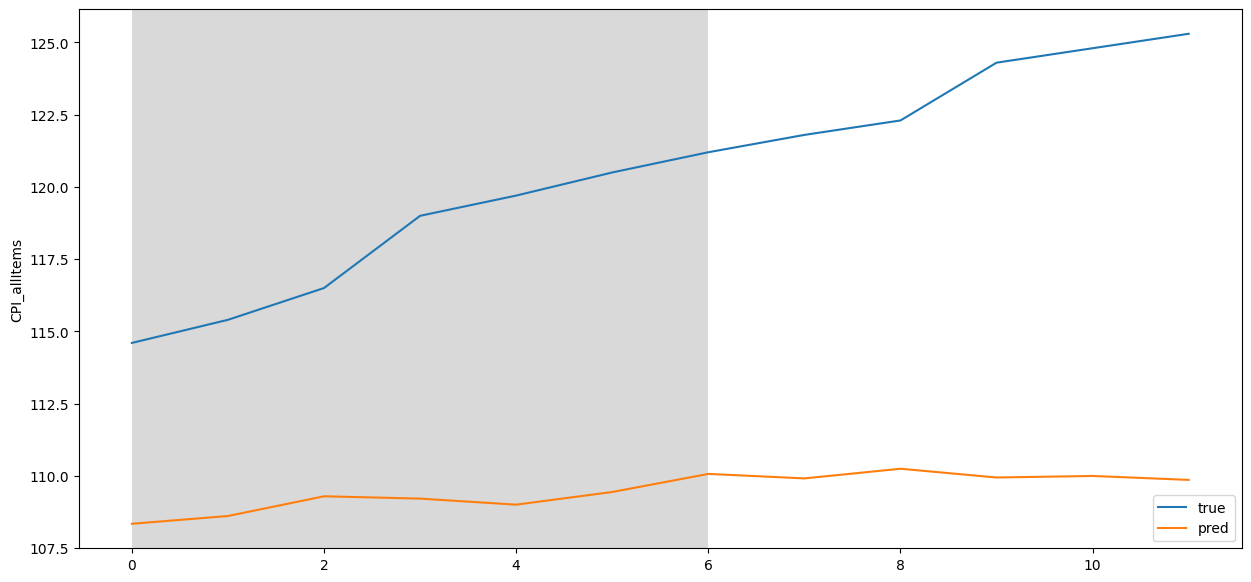

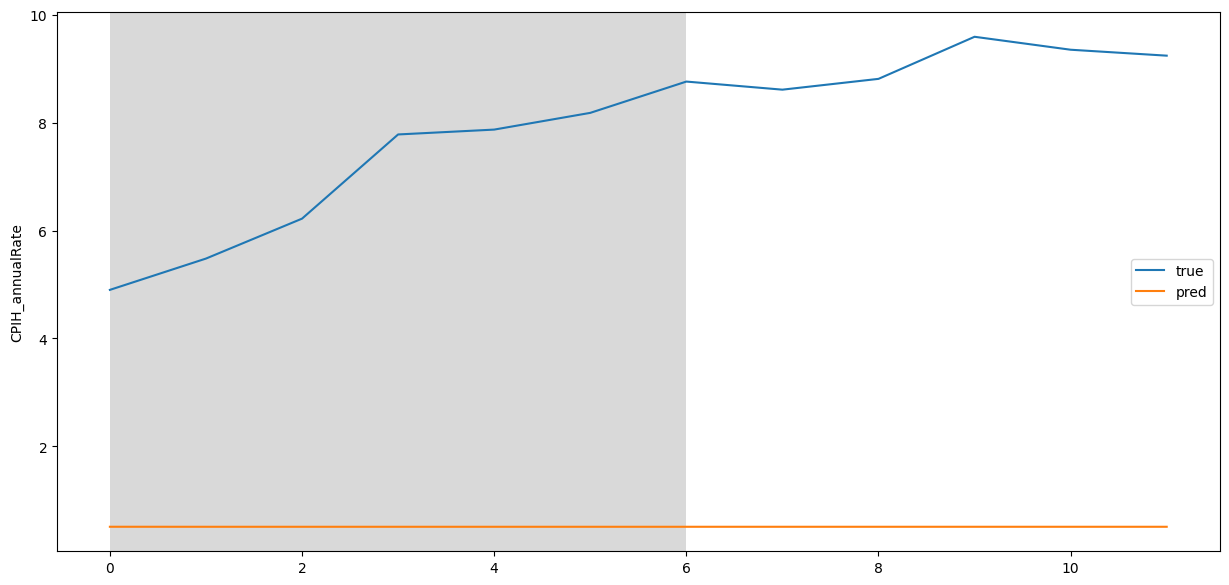

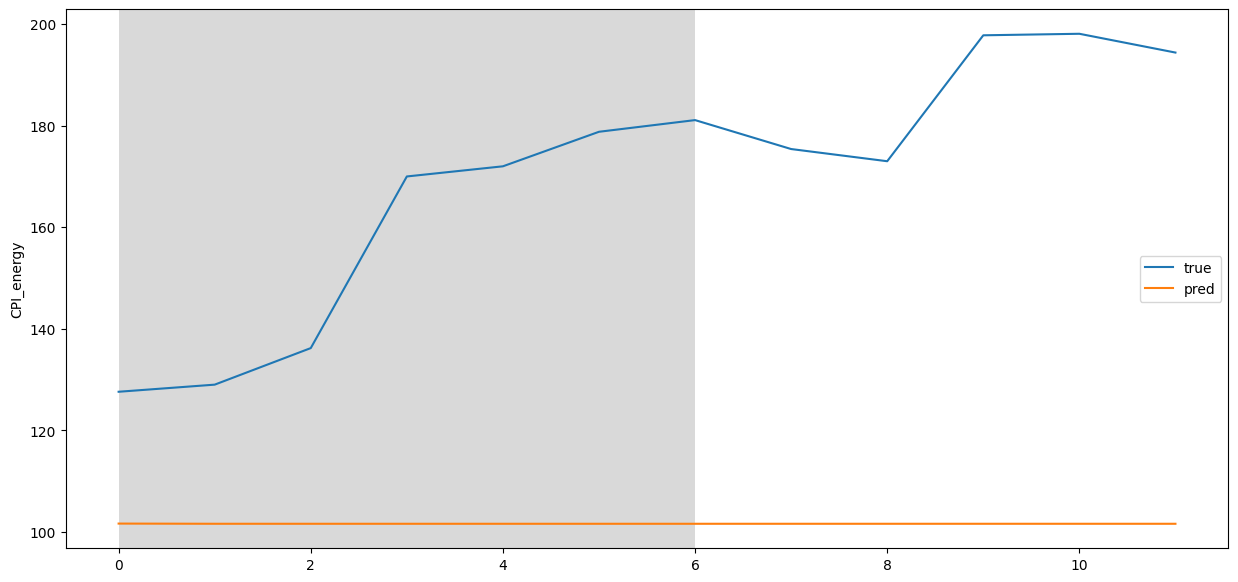

In [184]:
plot_comparison(start_idx=0, length=12, train=False)

## Random Forest

In [ ]:
X_train, X_test, y_train, y_test = indicators_train.values, indicators_test.values, inflation_train['CPIH_annualRate'].values, inflation_test['CPIH_annualRate'].values

In [ ]:
learner = RandomForestRegressor()

learner.fit(X_train, y_train)

results = {}

predictions_test = learner.predict(X_test)
predictions_train = learner.predict(X_train)

results['acc_train'] = mean_squared_error(y_train, predictions_train)

results['acc_test'] = mean_squared_error(y_test, predictions_test)

In [ ]:
results

{'acc_train': 0.06852126041666688, 'acc_test': 18.130624646666682}

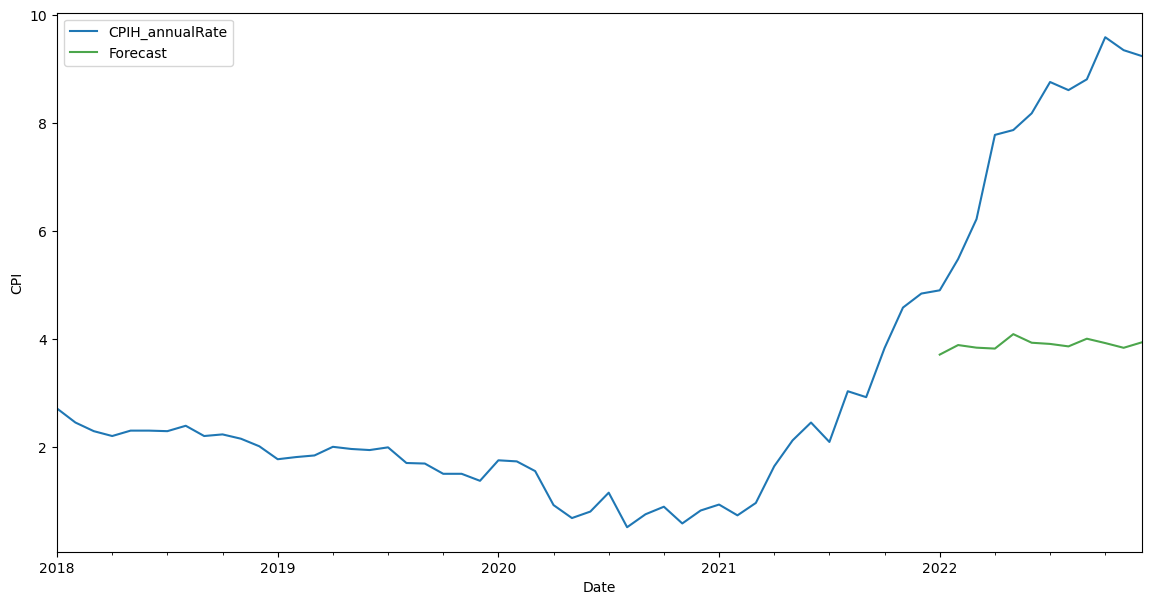

In [ ]:
ax = CPIH_annualRate.plot(label='Ground Truth')
pd.Series(predictions_test, index=inflation_test.index).plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7), color='green')

plt.plot(inflation_test.index, y_test, color='red')

ax.set_xlabel('Date')
ax.set_ylabel('CPI')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Month'>

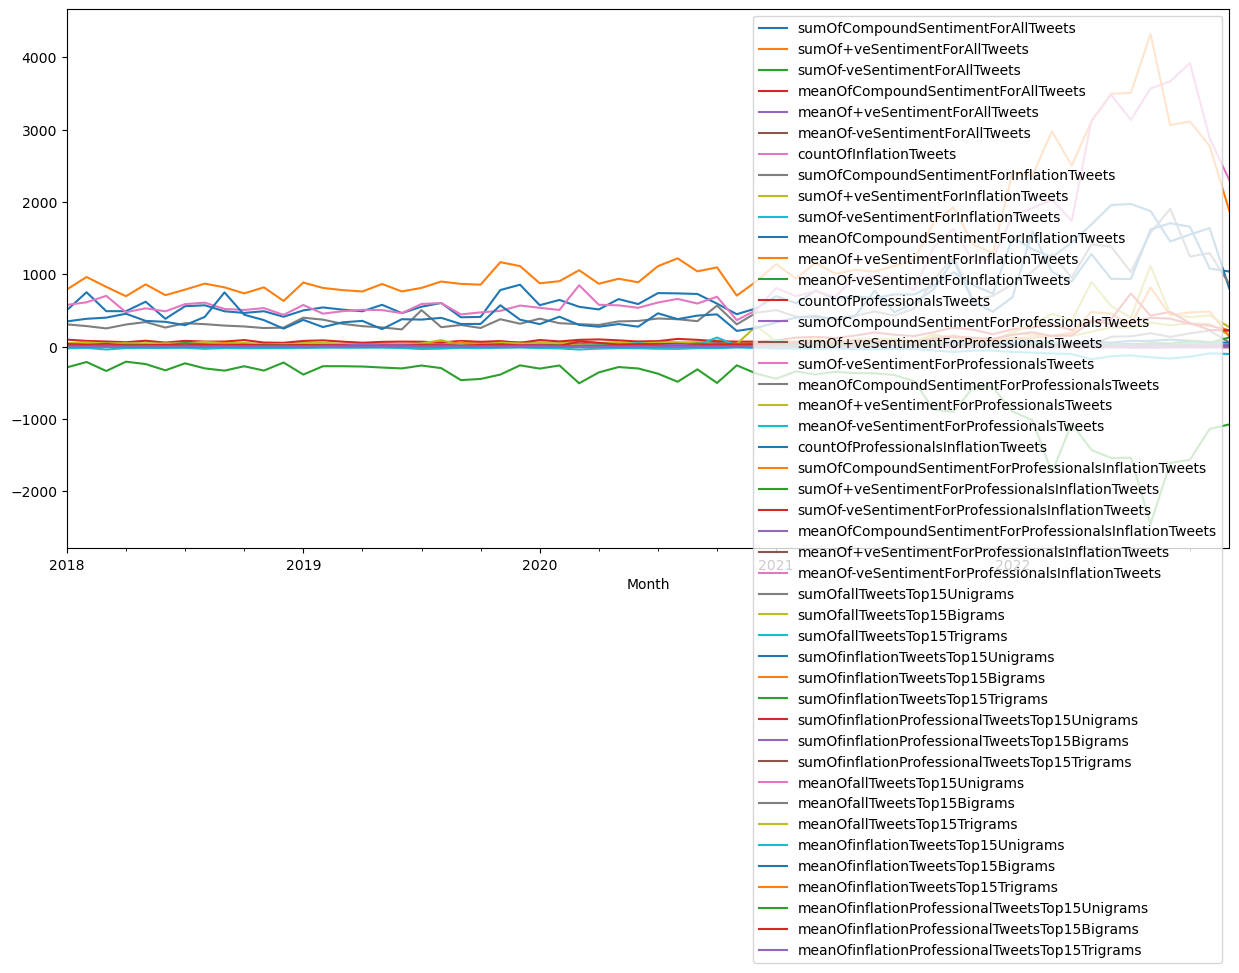

In [ ]:
indicators_df.drop(columns='countOfAllTweets').plot(figsize=(15,7))

In [ ]:
correlatedFeatures = ['sumOf-veSentimentForInflationTweets', 'meanOfCompoundSentimentForInflationTweets', 'meanOfallTweetsTop15Trigrams', 'sumOf-veSentimentForAllTweets',
'sumOfallTweetsTop15Unigrams', 'meanOfinflationTweetsTop15Bigrams',
       'countOfProfessionalsInflationTweets',
       'sumOfinflationProfessionalTweetsTop15Unigrams',
       'sumOfinflationTweetsTop15Unigrams', 'countOfProfessionalsTweets',
       'countOfInflationTweets', 'sumOfinflationTweetsTop15Bigrams'
]

indicators_train_2 = indicators_train[correlatedFeatures]
indicators_test_2 = indicators_test[correlatedFeatures]

In [ ]:
X_train, X_test, y_train, y_test = indicators_train_2.values, indicators_test_2.values, inflation_train['CPIH_annualRate'].values, inflation_test['CPIH_annualRate'].values

In [ ]:
learner = RandomForestRegressor(random_state=42)

learner.fit(X_train, y_train)

results = {}

predictions_test = learner.predict(X_test)
predictions_train = learner.predict(X_train)

results['acc_train'] = mean_squared_error(y_train, predictions_train)

results['acc_test'] = mean_squared_error(y_test, predictions_test)
results

{'acc_train': 0.05474924625000018, 'acc_test': 16.330649133333367}

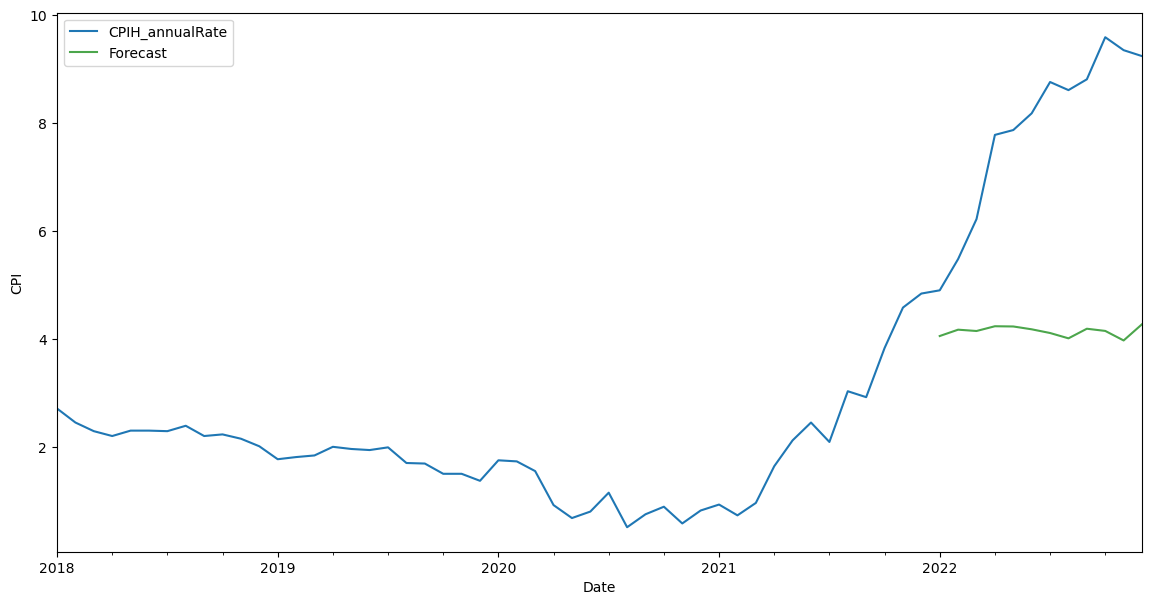

In [ ]:
ax = CPIH_annualRate.plot(label='Ground Truth')
pd.Series(predictions_test, index=inflation_test.index).plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7), color='green')

plt.plot(inflation_test.index, y_test, color='red')

ax.set_xlabel('Date')
ax.set_ylabel('CPI')
plt.legend()
plt.show()